In [14]:
import sys
sys.path.append('/home/s/seanmacb/Camera/pkgs')
sys.path.append('/home/s/seanmacb/Camera/pkgs/eo_pipe/python/lsst/eo/pipe')
import eo_pipe.python.lsst.eo.pipe as eo_pipe
from eo_pipe.python.lsst.eo.pipe import (readNoiseTask, darkCurrentTask, defectsTask, eperTask, divisaderoTearingTask, ptcPlotsTask,linearityPlotsTask, bfAnalysisTask)
import run_six_utils as rsu
import myutils_ar.myutils as myu
import lsst.afw.display as afwDisplay
import lsst.daf.butler as daf_butler
afwDisplay.setDefaultBackend('matplotlib')
import matplotlib.pyplot as plt
import numpy as np
import lsst.afw.image as afwImage
from lsst.afw.image import Mask
import lsst.geom as geom
from matplotlib.lines import Line2D
from run_six_utils import defectMaskComparison

In [15]:
# run5List = # Anything after 13280, but eo_pipe was never run on these
run6List = [13391,13392, 13401, 13420,13421]
run6bList = [13505, 13513,13550,13557]

allRuns = []
for runList in [run6List, run6bList]:
    for entry in runList:
        allRuns.append(entry)

bay_slot_science = []
bay_slot_other =[]
for bay_slot in list(myu.det_names.values()):

    det = myu.camera.getNameMap()[bay_slot]
    if str(det.getType())=="DetectorType.SCIENCE" and bay_slot not in bay_slot_science:
        bay_slot_science.append(bay_slot)
    elif bay_slot not in bay_slot_other:
        bay_slot_other.append(bay_slot)
    del det

E2V_Bay,ITL_Bay = [],[]
for bay_slot in bay_slot_science:
    det = myu.camera.getNameMap()[bay_slot]
    if det.getPhysicalType()=="ITL" and bay_slot[0:3] not in ITL_Bay:
        ITL_Bay.append(bay_slot[0:3])
    elif det.getPhysicalType()=="E2V" and bay_slot[0:3] not in E2V_Bay:
        E2V_Bay.append(bay_slot[0:3])

repo = "/repo/ir2"
collections = 'LSSTCam/raw/all,LSSTCam/calib'.split(",")

# Get all detector information
df_dict = {}
for defect_type in ["eo_dark_defects"]:
    for acq_run in allRuns:
        repo = "/repo/main" if acq_run>13999 else "/repo/ir2"
        butler = rsu.makeButler(repo,collections)
        collection = butler.registry.queryCollections(f"*{defect_type}*{str(acq_run)}*",
                                                       collectionTypes=daf_butler.CollectionType.CHAINED)
        df_dict[int(acq_run)] = myu.eopipe_DictToDfz(eo_pipe.get_amp_data(repo,collection)) # For each run

# Drop all rows that contain information about non-science detectors
for run in list(df_dict.keys()):
    drop_index = []
    for entry,ind in zip(df_dict[run]["BAY_SLOT"],df_dict[run].index):
        if entry in bay_slot_other:
            drop_index.append(ind)
    df_dict[run].drop(drop_index,inplace=True)

# Figures of eo_pipe run comparisons

### Raw number

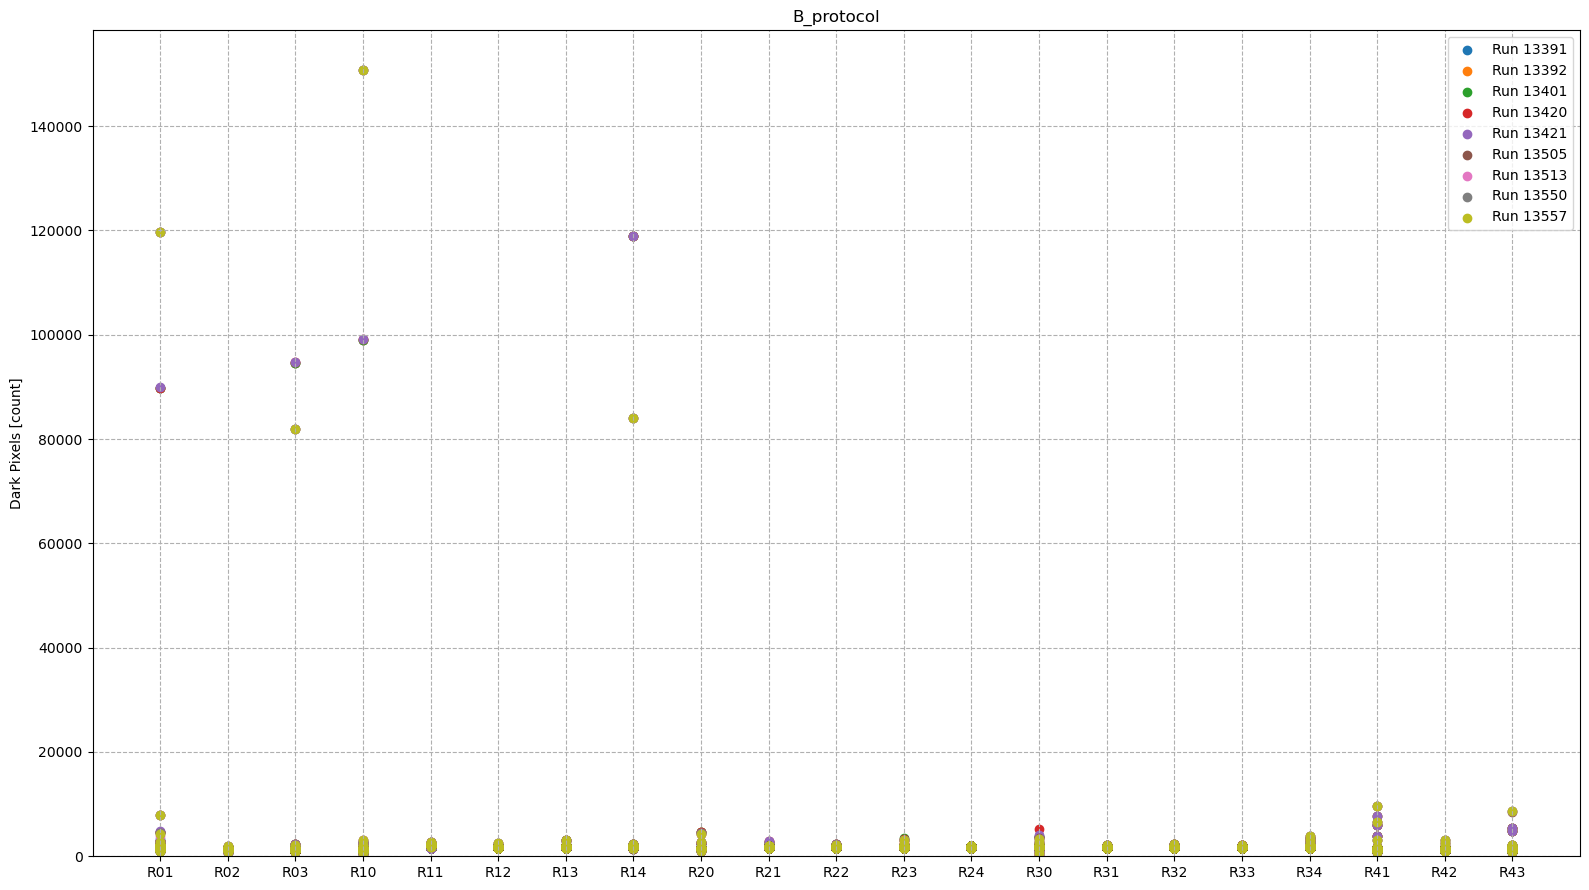

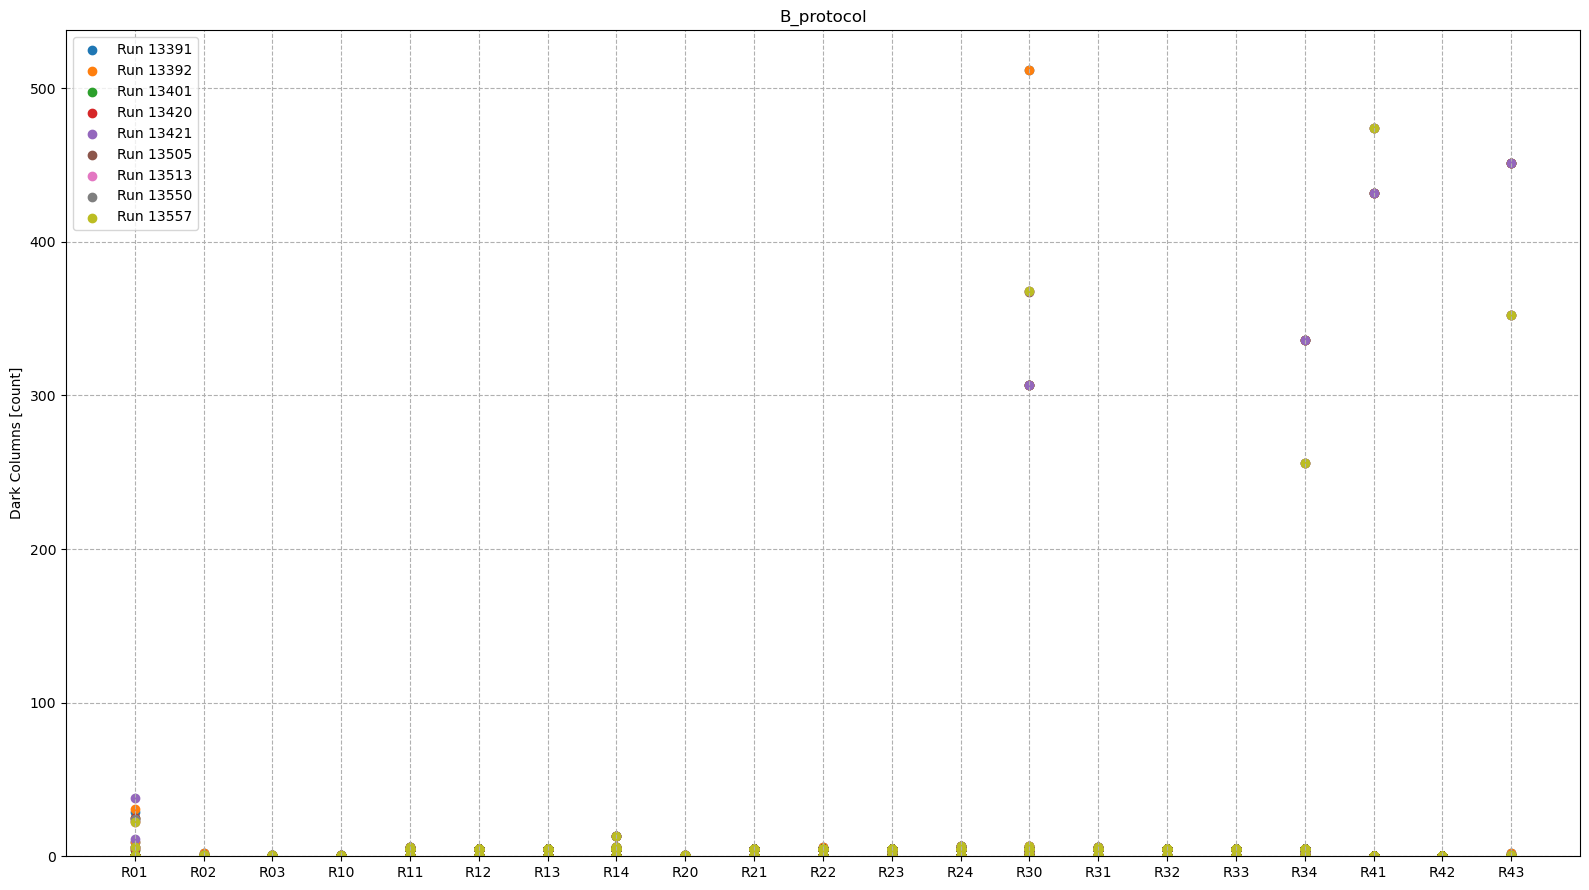

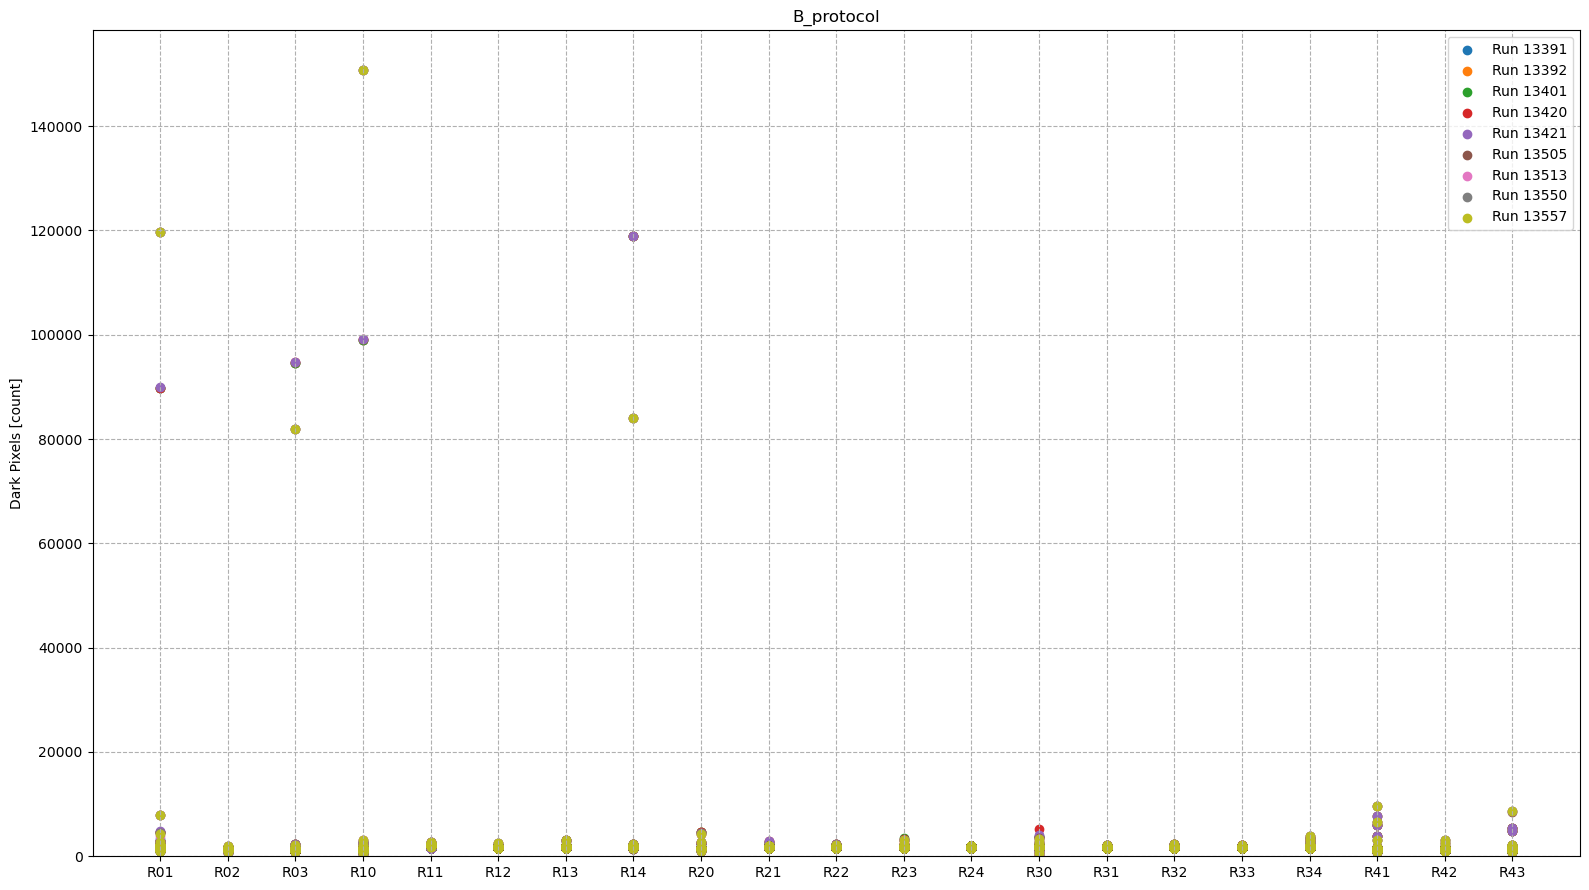

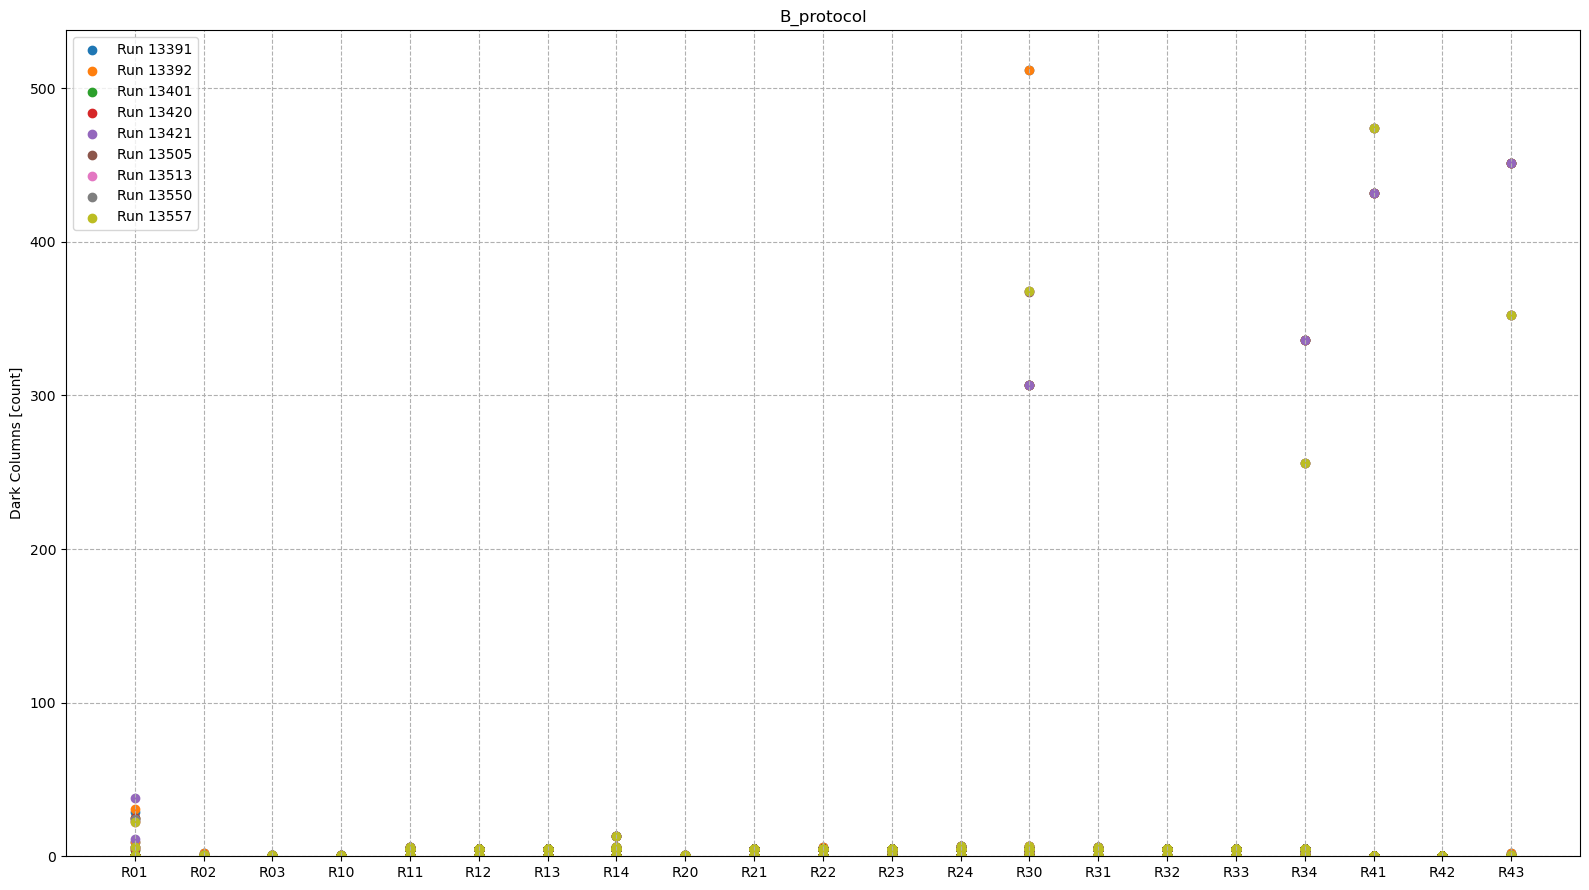

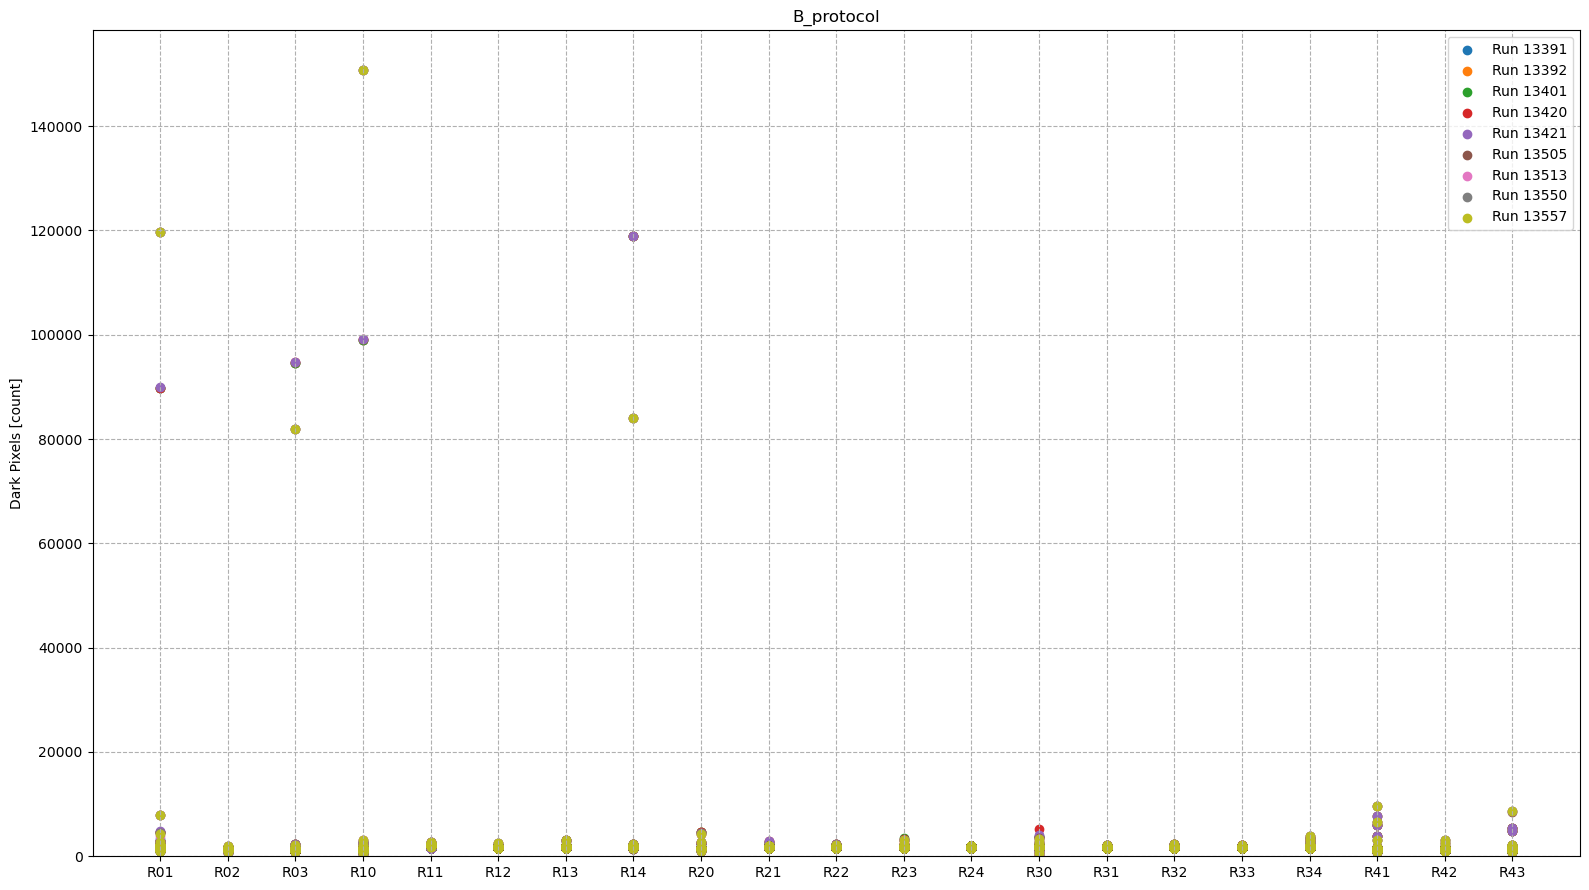

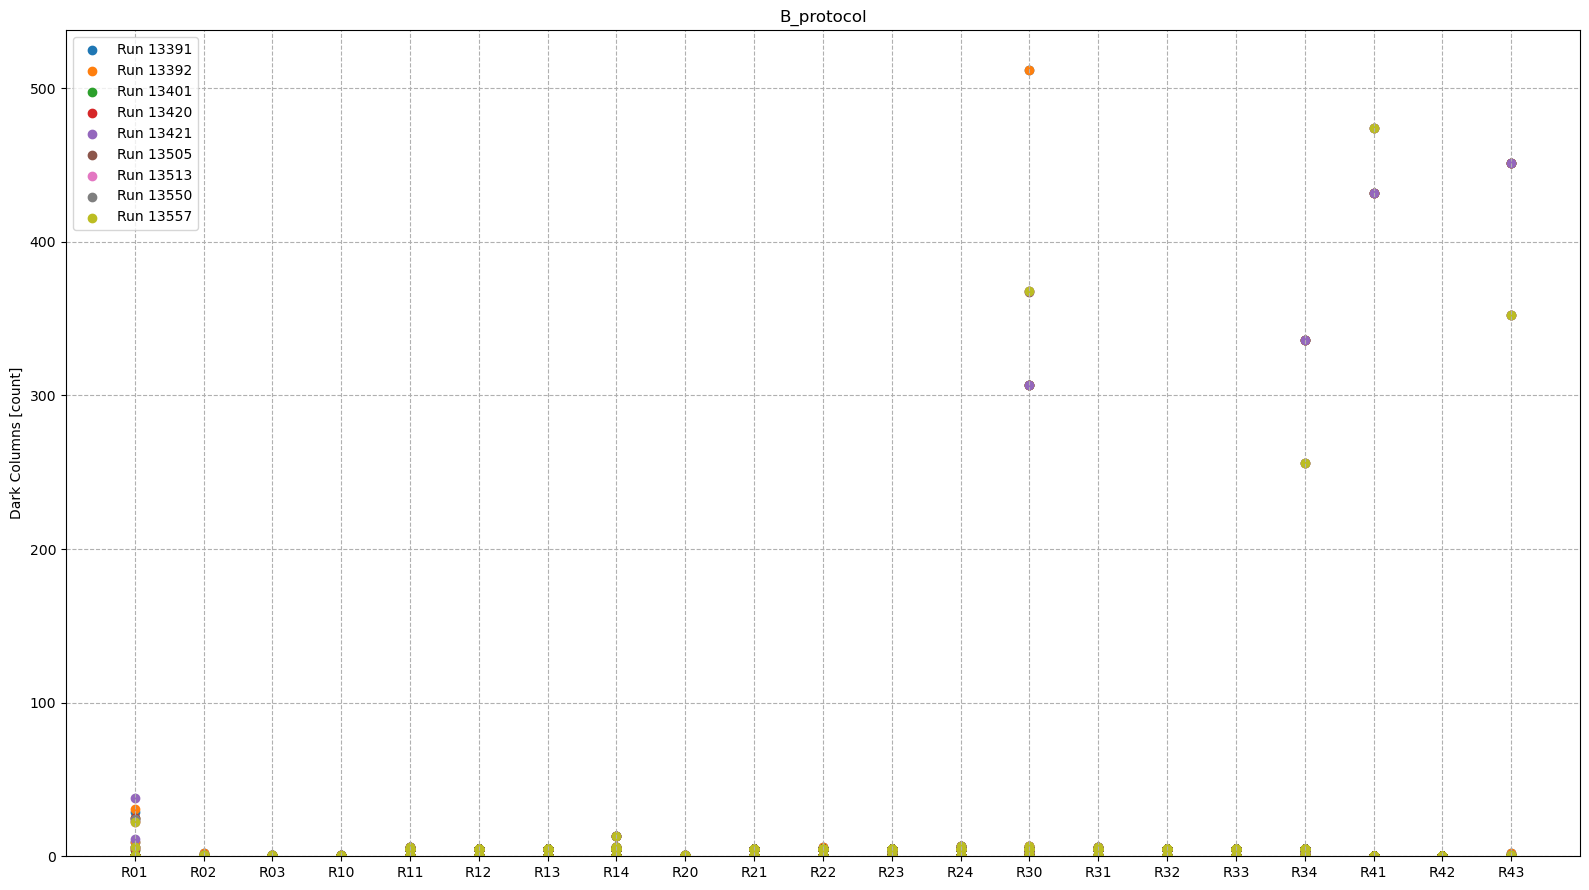

In [16]:
for runList in [run6List, run6bList,allRuns]:
    for colName in ["PIXELS","COLUMNS"]:
        
        fig,ax = plt.subplots(figsize=[16,9])
    
        for run in list(df_dict.keys()):
            ax.scatter(df_dict[run]["BAY"],df_dict[run]["DARK_{}".format(colName)],label="Run {}".format(run))
        
        ax.legend()
        ax.set_ylabel("Dark {} [count]".format(colName.title()))
        __,hi = ax.get_ylim()
        ax.set_ylim(0,hi)
        ax.grid(ls='--')
        ax.set_title("B_protocol")
        
        fig.tight_layout()
    
        plt.show()

In [17]:
run6Dict,run6bDict = {},{}
for key in list(df_dict.keys()):
    if key in run6List:
        run6Dict[key] = df_dict[key]
    if key in run6bList:
        run6bDict[key] = df_dict[key]

### Comparison to a baseline

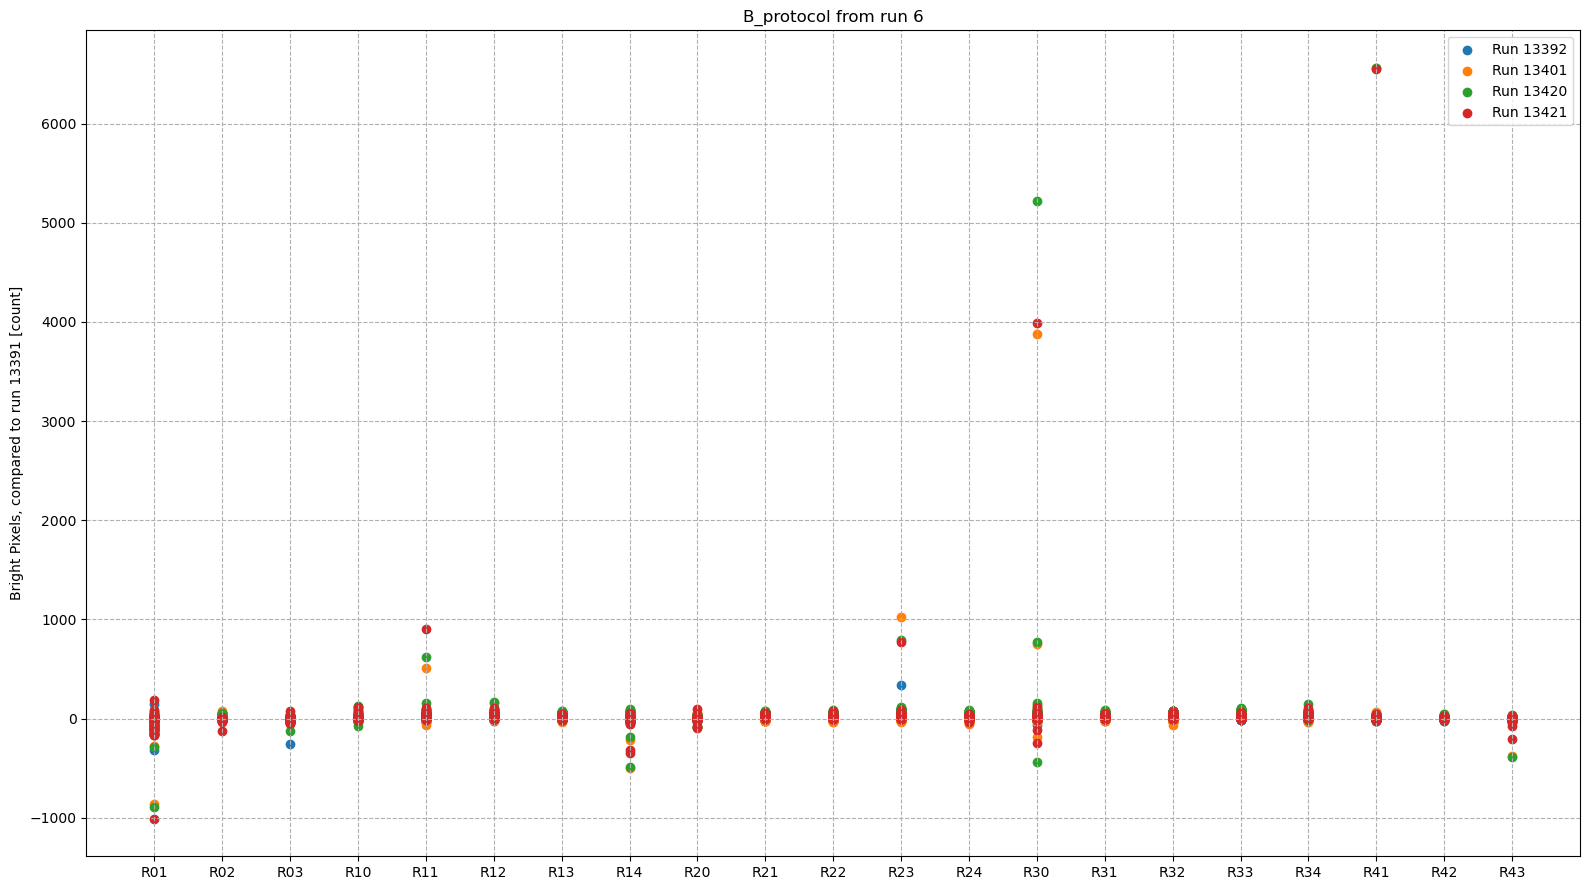

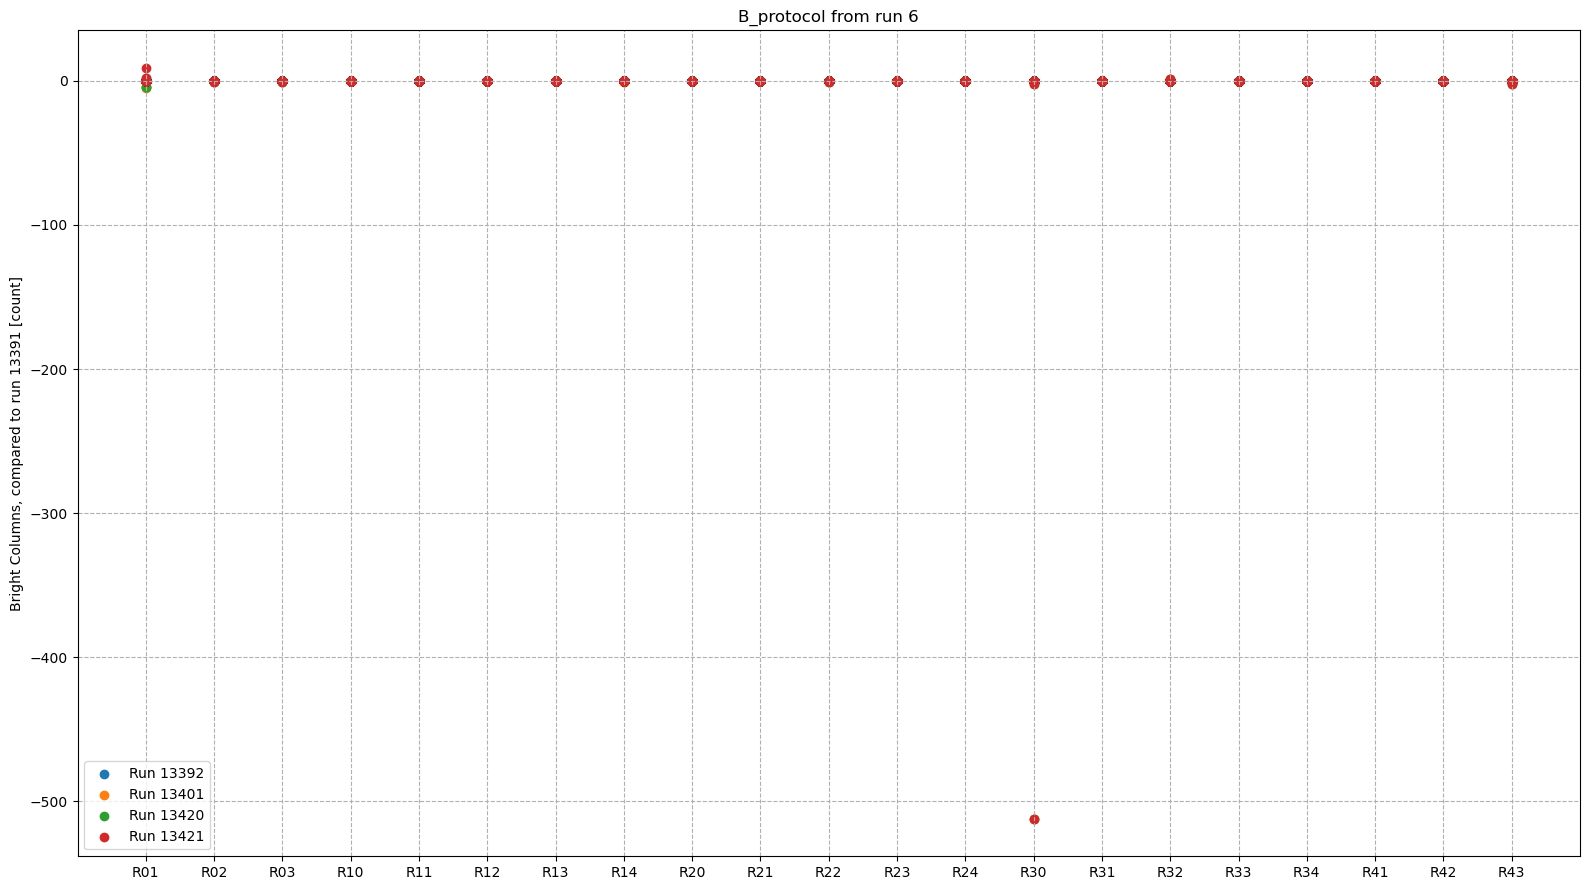

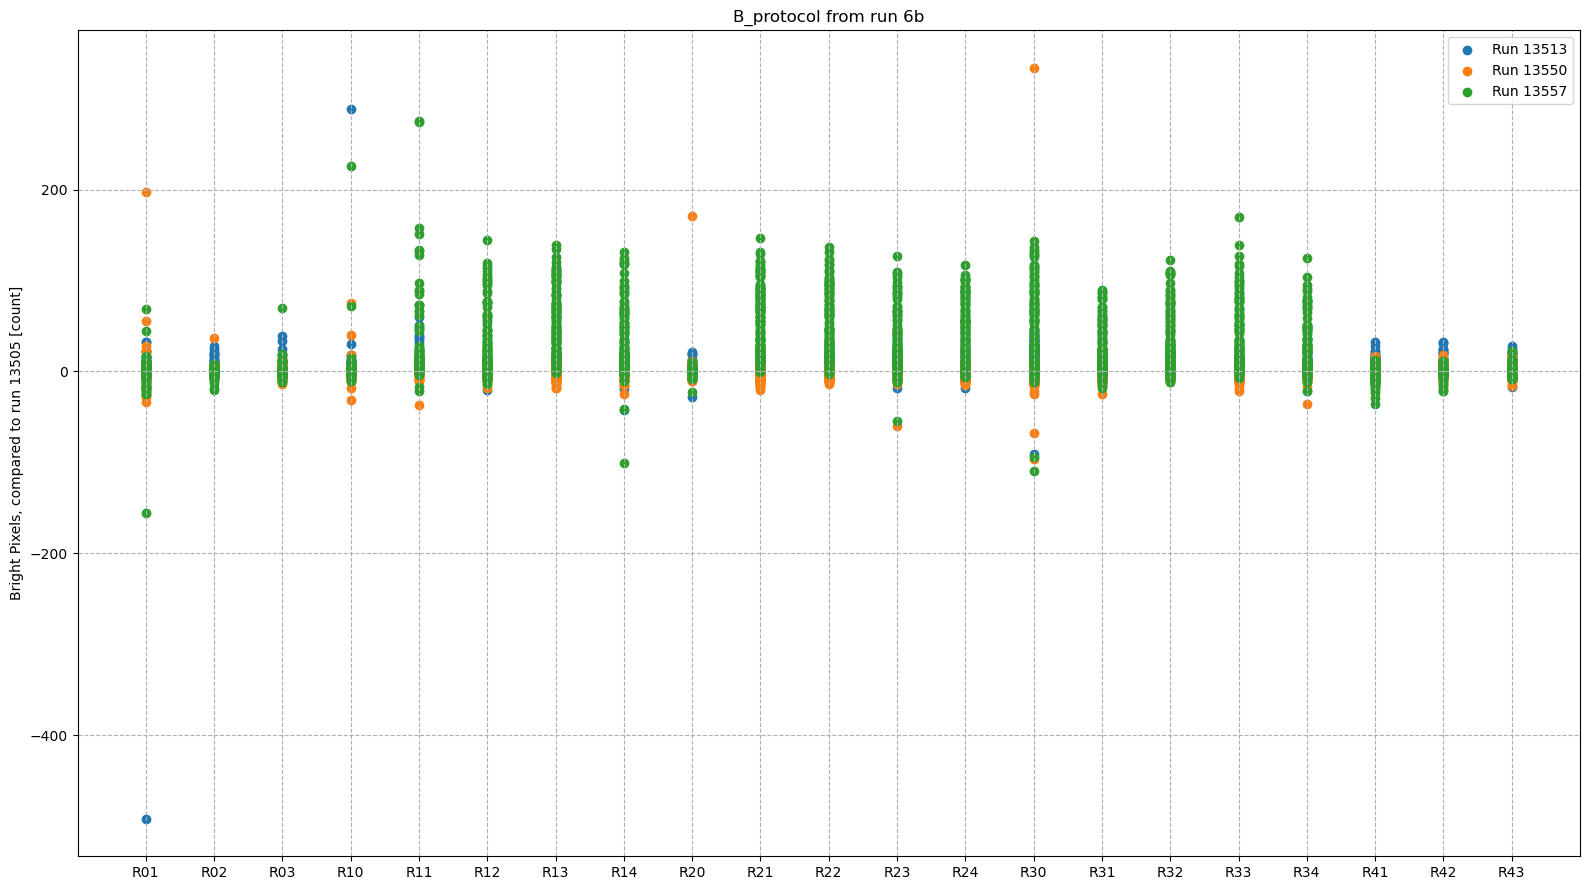

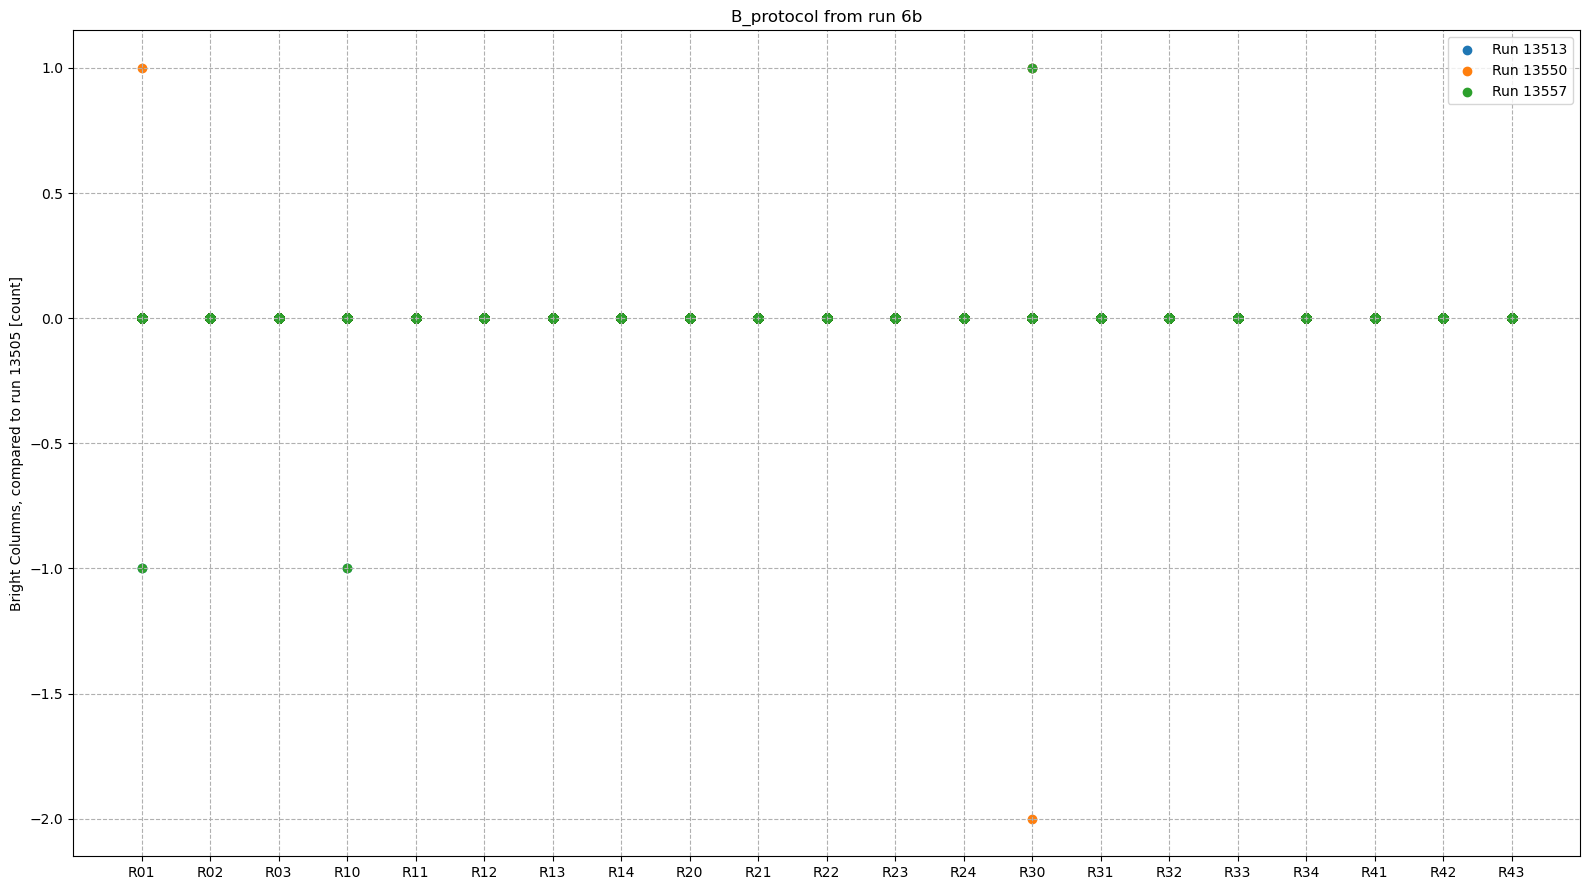

In [18]:
for runDict,runLabl in zip([run6Dict,run6bDict],["6","6b"]):
    allRuns = list(runDict.keys())
    baseline_run = allRuns[0]
    
    baseline_brightPixels = runDict[baseline_run]["DARK_PIXELS"]
    baseline_brightColumns = runDict[baseline_run]["DARK_COLUMNS"]
    
    for colName,baseline in zip(["PIXELS","COLUMNS"],[baseline_brightPixels,baseline_brightColumns]):
        
        fig,ax = plt.subplots(figsize=[16,9])
    
        for run in allRuns[1:]:
            ax.scatter(runDict[run]["BAY"],runDict[run]["DARK_{}".format(colName)] - baseline,label="Run {}".format(run))
        
        ax.legend()
        ax.set_ylabel("Bright {}, compared to run {} [count]".format(colName.title(),baseline_run))
        
        ax.grid(ls='--')
        ax.set_title("B_protocol from run {}".format(runLabl))
        
        fig.tight_layout()
    
        plt.show()

### Same two plots as above, but get more granular. Get down to raft level
### Further divide the detectors by type: E2V and ITL

In [19]:
oneDim = 1

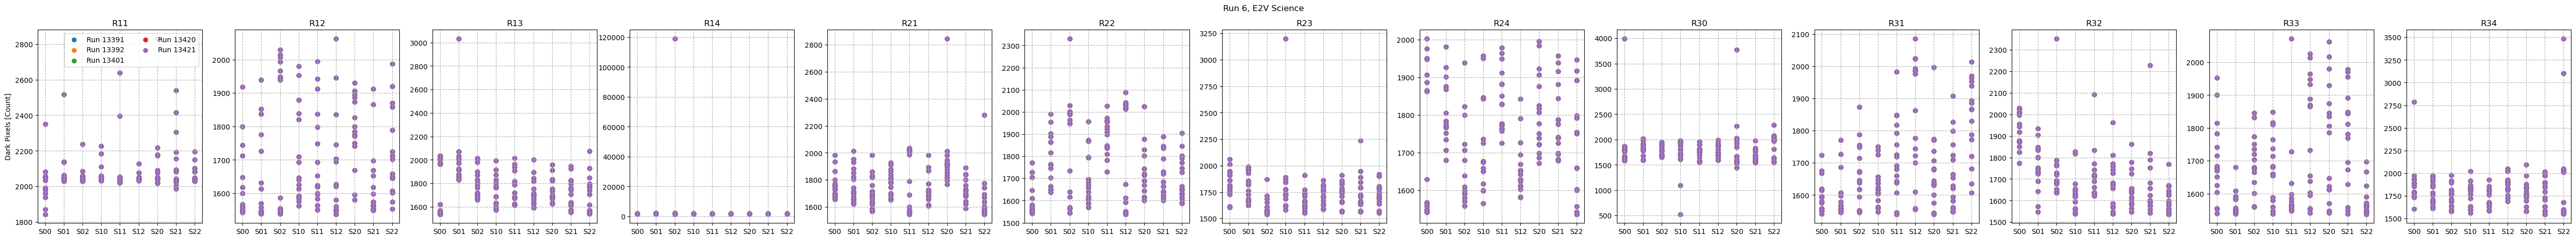

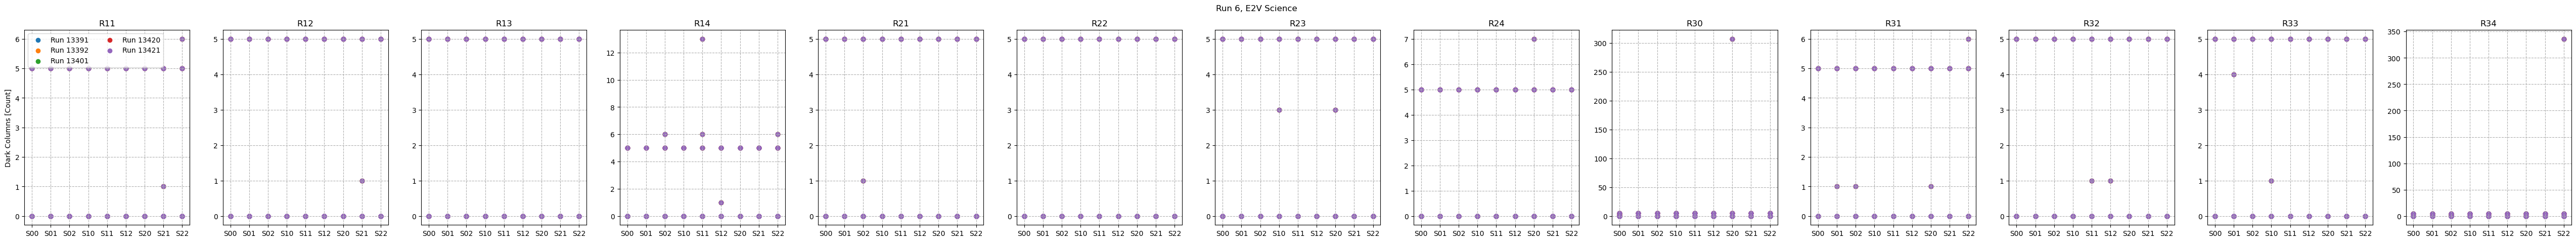

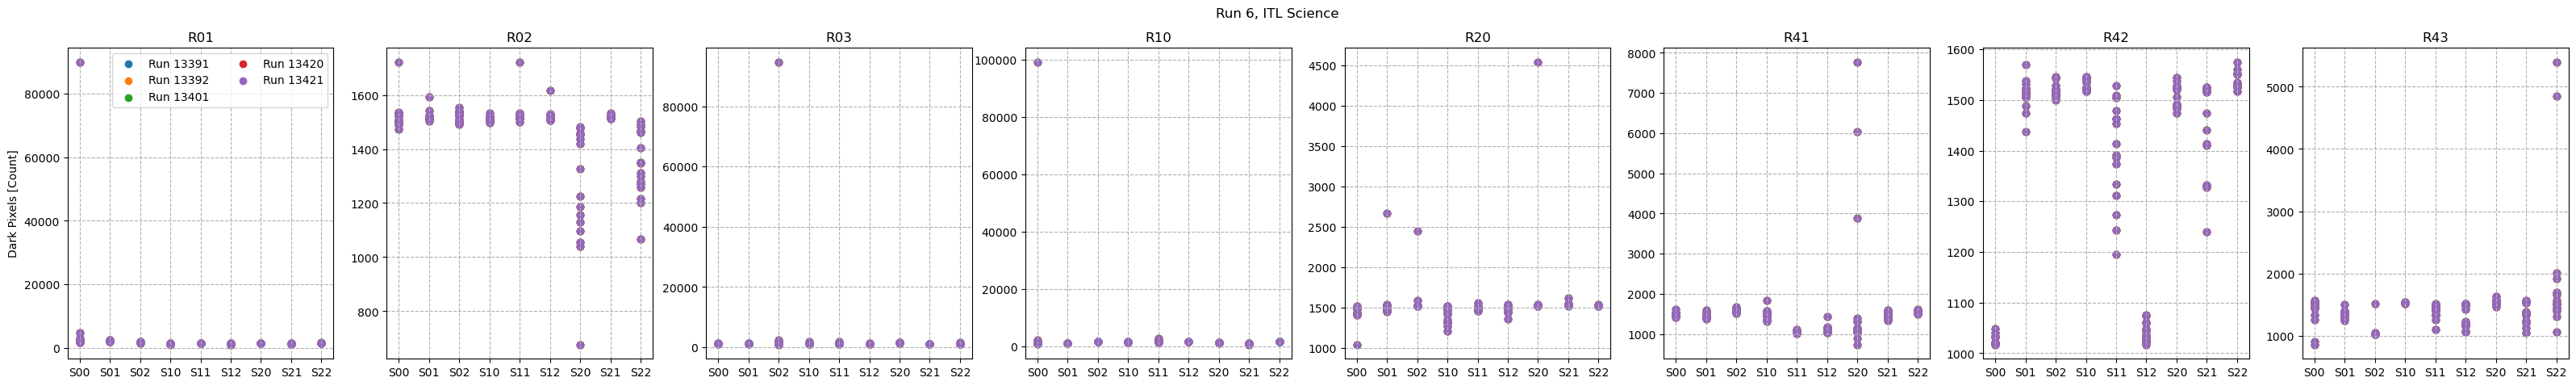

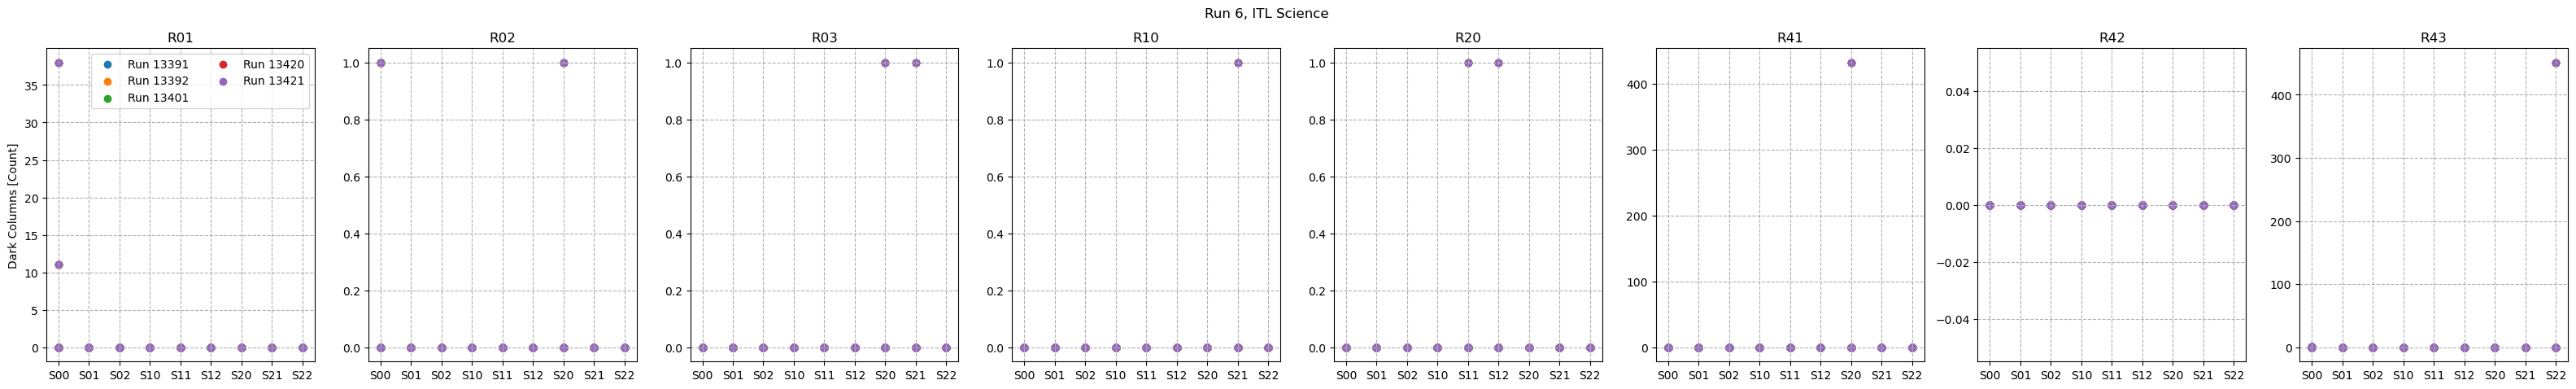

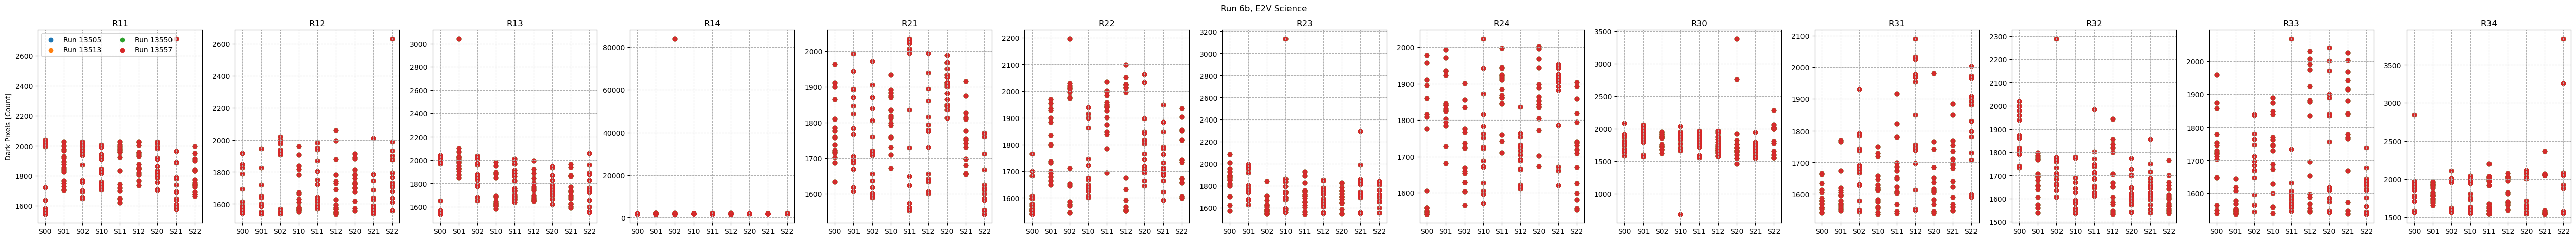

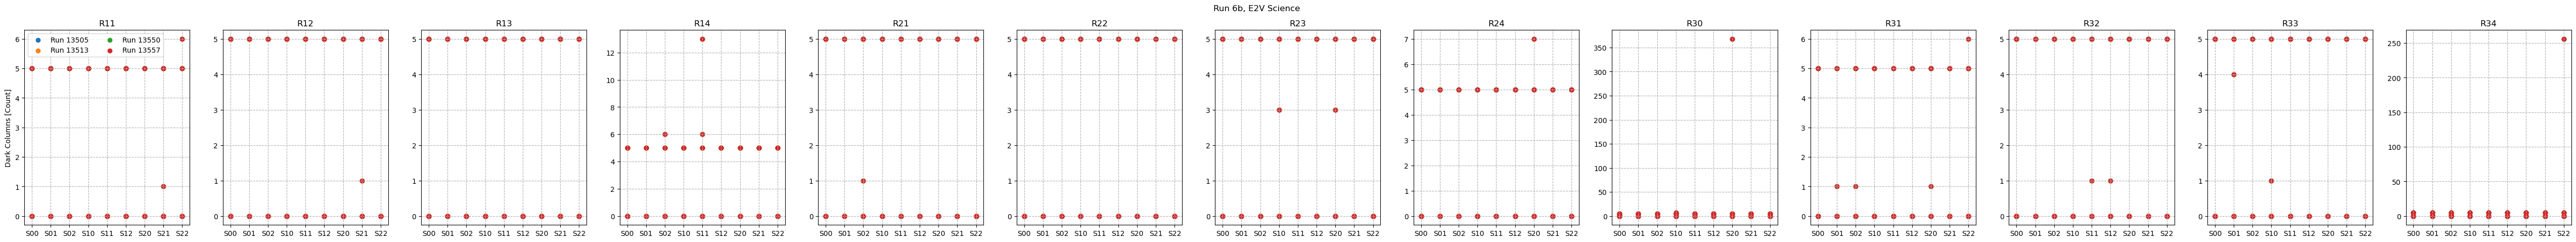

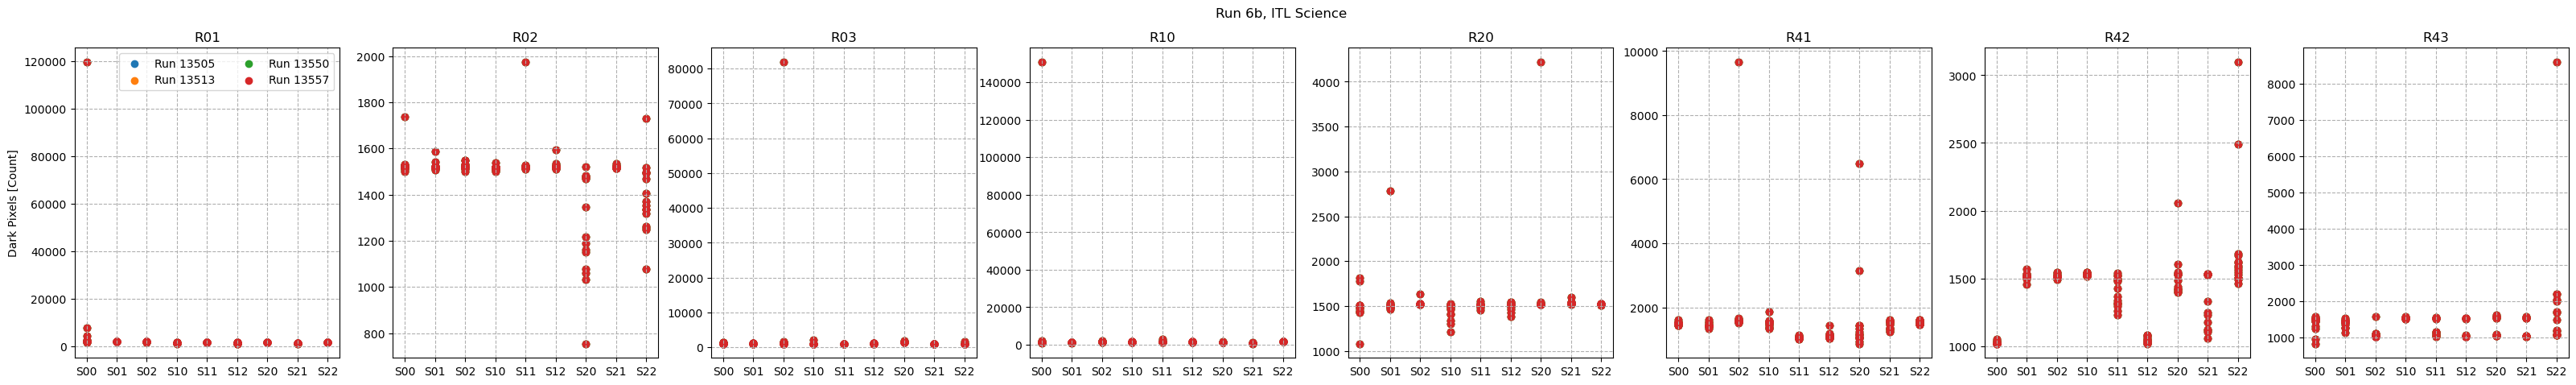

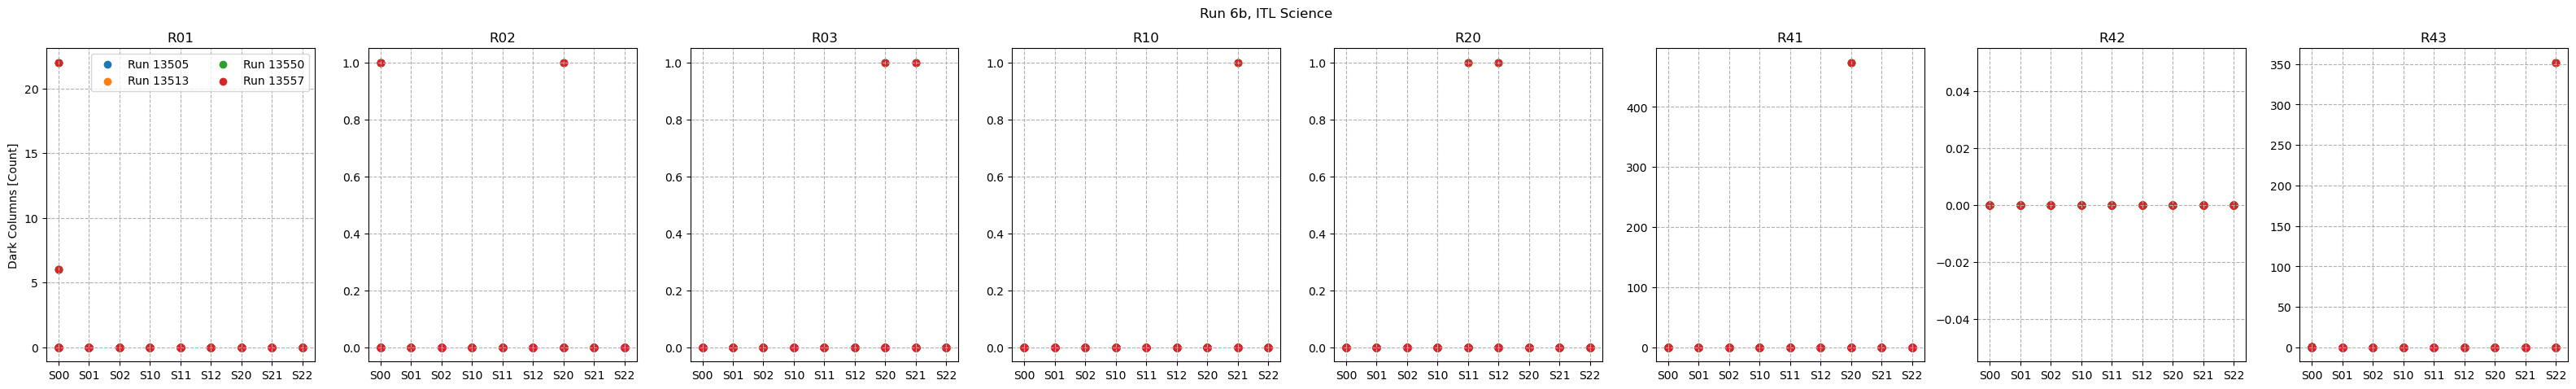

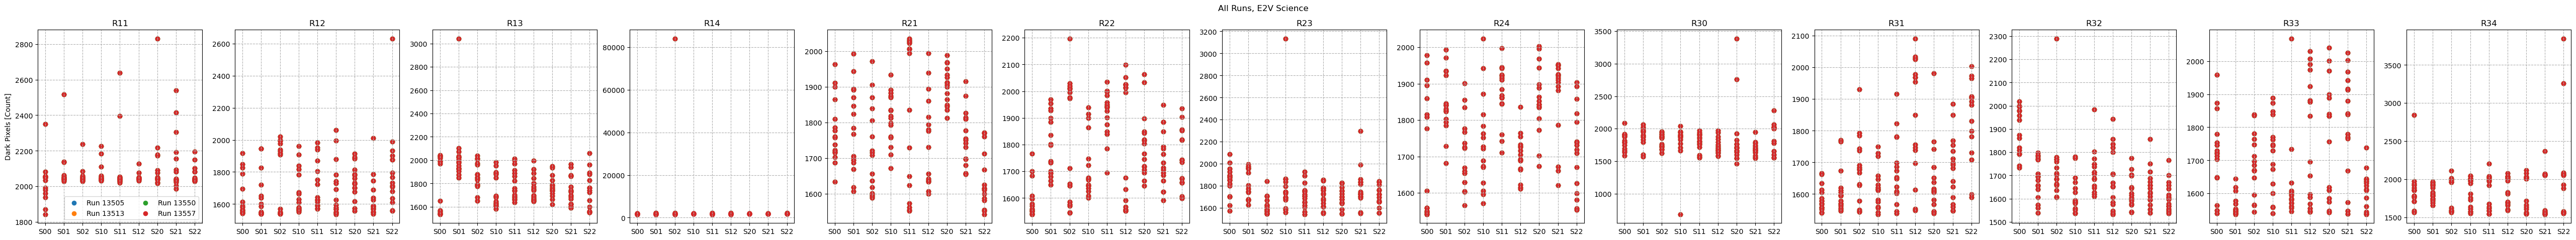

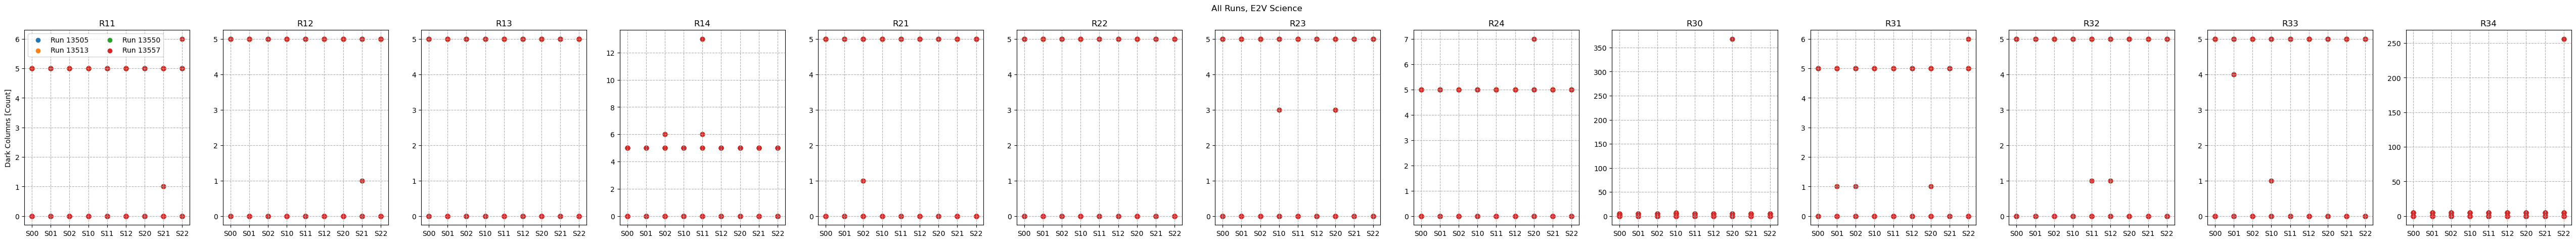

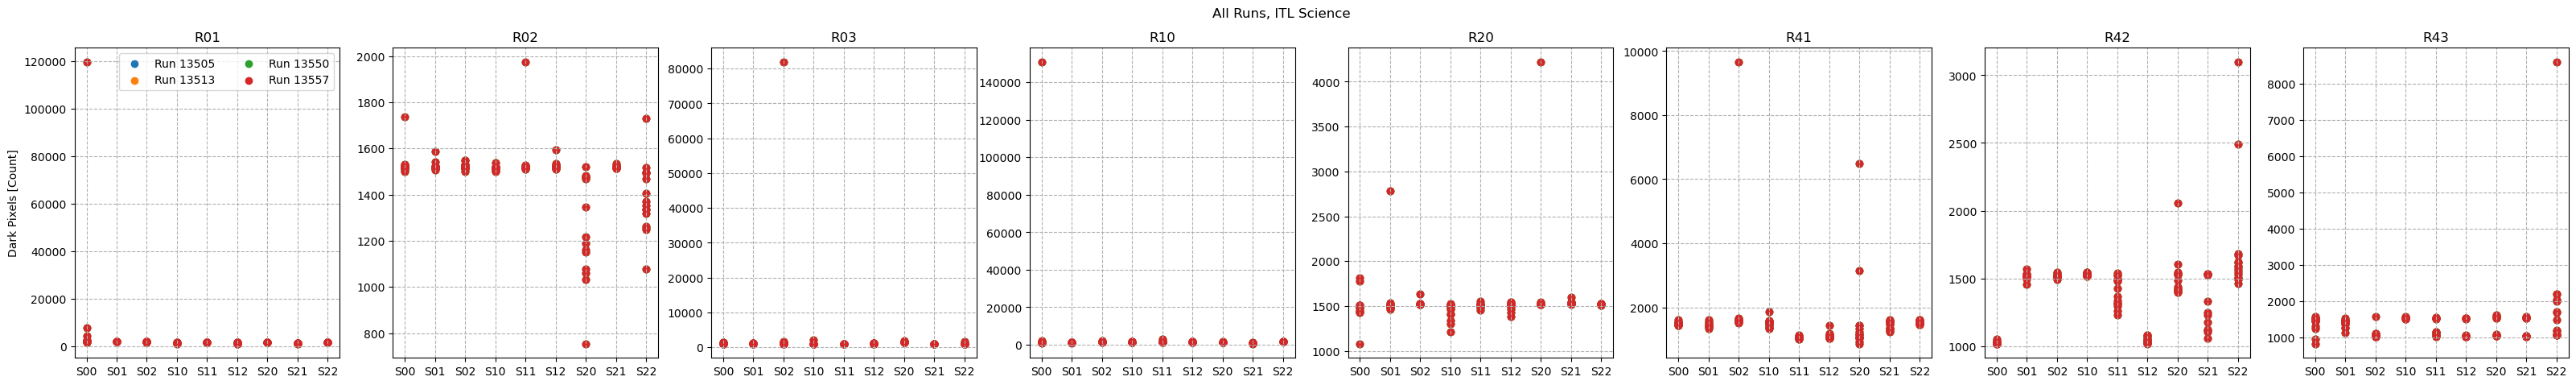

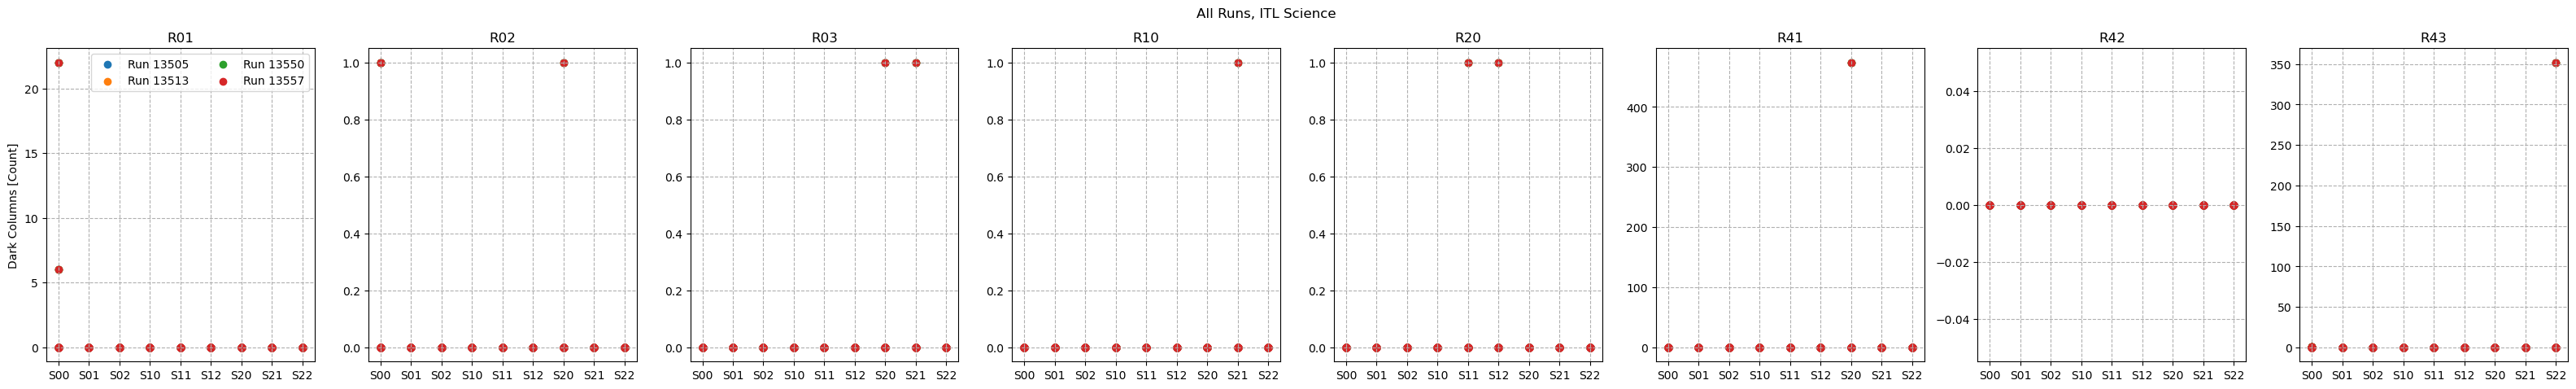

In [20]:
for runList,runLabl in zip([run6List, run6bList,allRuns],["Run 6","Run 6b","All Runs"]):
    for raftList,manuLabel in zip([E2V_Bay,ITL_Bay],["E2V Science","ITL Science"]):
        for colName in ["PIXELS","COLUMNS"]:
            # Make figure
            figdim = (oneDim,len(raftList)//oneDim + len(raftList)%oneDim)
            fig,axs = plt.subplots(figdim[0],figdim[1],figsize=np.flip(np.dot(5,figdim)))
            
            axs_flattened = axs.flatten()
            
            fig.suptitle("{}, {}".format(runLabl,manuLabel))
            
            for raft,ax in zip(raftList,axs_flattened):
                df_subset = df_dict[run][df_dict[run]["BAY"]==raft]
                for run in runList:
                    ax.scatter(df_subset["SLOT"],df_subset["DARK_{}".format(colName)],label="Run {}".format(run))
                ax.title.set_text(raft)
                ax.grid(ls="--")
                if ax == axs[0]:
                    ax.legend(ncols=2)
                    ax.set_ylabel("Dark {} [Count]".format(colName.title()))
                del df_subset

### Go full focal plane now
- Average statistics on the defect evolution through run 6 --> run 6b

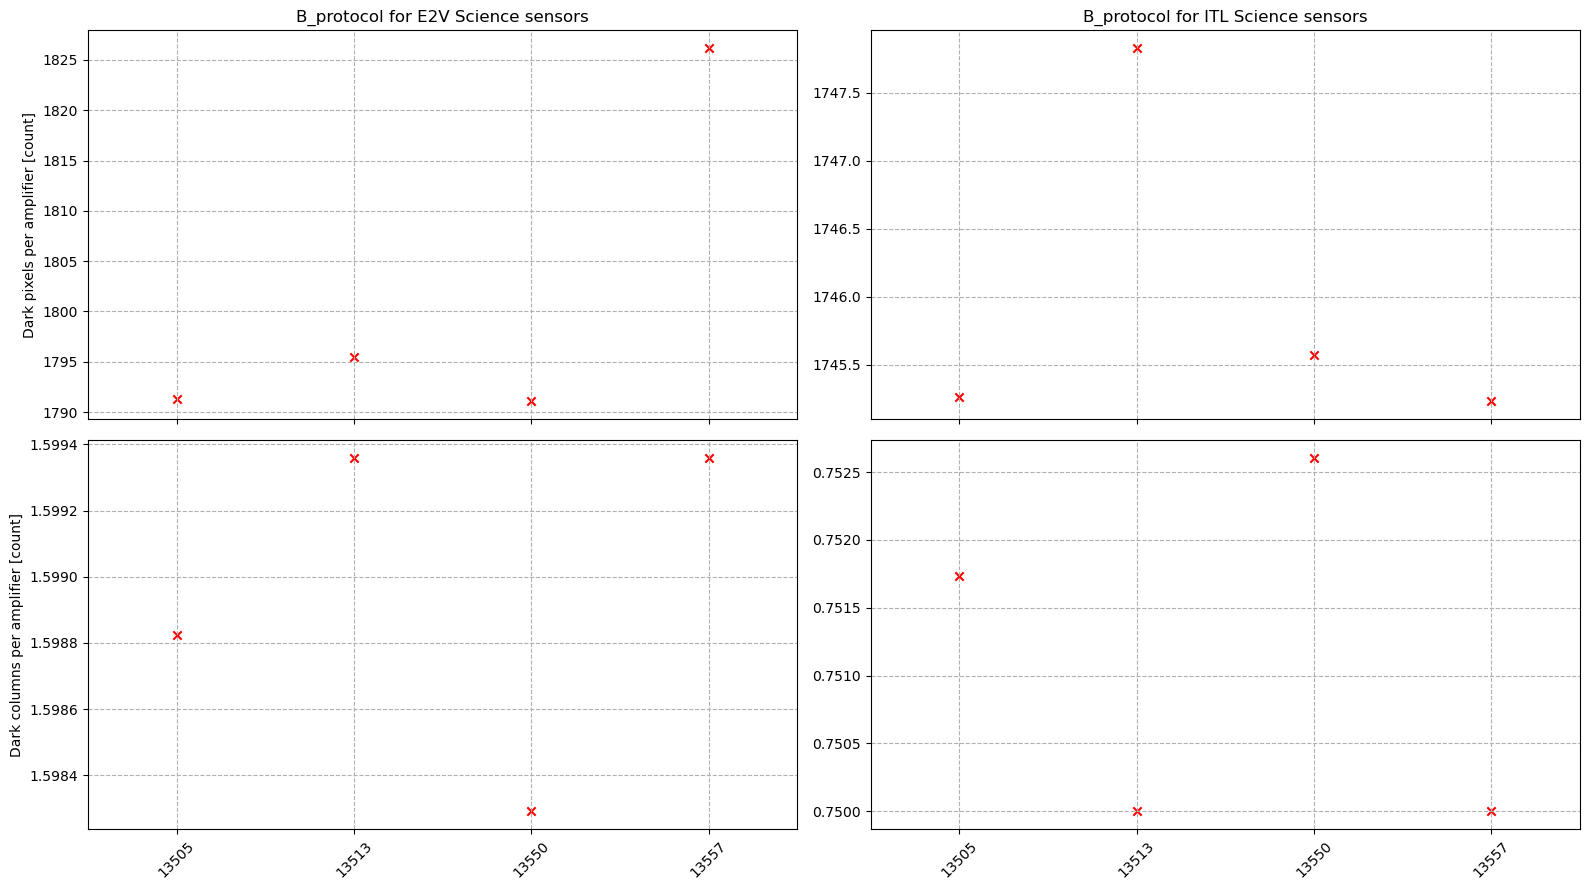

In [21]:
fig,axs = plt.subplots(2,2,figsize=[16,9],sharex=True)
axs_flattened = axs.flatten()
for raftList,manuLabel,ax,colName in zip([E2V_Bay,ITL_Bay,E2V_Bay,ITL_Bay],["E2V Science","ITL Science",None,None],axs_flattened,["PIXELS","PIXELS","COLUMNS","COLUMNS"]):
    # for colName in ["PIXELS","COLUMNS"]:
    for run,ind in zip(allRuns,range(len(allRuns))):
        # Select run, raftType
        df_mask = [i in raftList for i in df_dict[run]["BAY"]]
        df_subset = df_dict[run][df_mask]
        ax.scatter(ind,df_subset["DARK_{}".format(colName)].mean(),color='red',marker='x',label="Dark {} [count]".format(colName.title()) if run==allRuns[0] else None)
            
    if ax == axs_flattened[0]:
        ax.set_ylabel("Dark pixels per amplifier [count]")
    elif ax == axs_flattened[2]:
        ax.set_ylabel("Dark columns per amplifier [count]")

    ax.set_xticks(np.arange(len(allRuns)))
    ax.set_xlim(np.min(np.arange(len(allRuns)))-0.5,np.max(np.arange(len(allRuns)))+0.5)
    ax.xaxis.set_ticklabels([str(s) for s in allRuns], rotation=45, fontsize=10)
    
    lo,hi = ax.get_ylim()
    ax.vlines(4.5,lo-10,hi+10,ls = "--") # Add a vline denoting run 6 vs run 6b
    ax.set_ylim(lo,hi)

    # if ax == axs_flattened[0] or ax == axs_flattened[1]:
    #     ax.set_ylim(11,12)
    # elif ax == axs_flattened[2]:
    #     ax.set_ylim(0.071,0.073)
    # else:
    #     ax.set_ylim(0.61,0.63)
        
        
    
    ax.grid(ls='--')
    if manuLabel!=None:
        ax.set_title("B_protocol for {} sensors".format(manuLabel))
    
    fig.tight_layout()
    
        # plt.show()

In [22]:
# df_subset["BRIGHT_COLUMNS"][[(i != "R01_S00" and i != "R43_S00" and  i != "R43_S12") for i in df_subset["BAY_SLOT"]]].mean()
# refinedList

### Uniqueness

Here, look at the uniqueness of a defect mask across these runs
- Start with the defect mask across all runs
- Compare all other unique combos (similar to subfigure in previous figure)

In [23]:
reAnalyze = False
writePath = "/home/s/seanmacb/Camera/DefectAnalysis/Data/DefectUniqueness/defectUniqueness_RefinedList_dark.txt"
refinedList = [13392, 13401, 13420,13505, 13513, 13550]

In [24]:
if reAnalyze:
    start = 0
    dataDict = {}
    
    for detector,seg,iterator in zip(df_dict[list(df_dict.keys())[0]]["BAY_SLOT"],df_dict[list(df_dict.keys())[0]]["SEGMENT"],range(len(df_dict[list(df_dict.keys())[0]]["BAY_SLOT"]))):
        # # Do setup for this amp
        # maskArrayList = []
        # maskList = []
        # mask = defectMaskComparison(myu.det_nums[detector])
        # for run in refinedList:
        #     mask.setRun(run)
        #     mask.setDetectorObj(myu.det_nums[detector])
        #     mask.setAmplifier(seg)
        #     mask.applyMaskToImage("eo_bright_defects","eoBrightDefects")
    
        #     maskArrayList.append(mask.maskArray)
        #     runList.append(run


        #                    ###

        # Do setup for this amp
        maskArrayList = []
        maskList = []
        mask = defectMaskComparison(myu.det_nums[detector])
        for run in refinedList:
            mask.setRun(run)
            mask.setDetectorObj(myu.det_nums[detector])
            mask.setAmplifier(seg)
            mask.applyMaskToImage("eo_bright_defects","eoBrightDefects")
    
            maskArrayList.append(mask.maskArray)
            runList.append(run)
        mask.combineMasks(maskArrayList,runList)
        

        if mask.runList != refinedList:
            print("Failed on detector {}, segment {}".format(detector,seg))
    
        # # mask.combineMasks(maskArrayList,runList) # Combine the masks

        # finalList = np.zeros(np.shape(maskArrayList[0]))
        # for maskList, myiter in zip(maskArrayList,range(len(maskArrayList))):
        #     finalList += maskList * 2**myiter
    
        returns = np.unique(mask.ampMaskArray,return_counts = True)
        
        dataDict[detector+"_"+seg] = [list(returns[0].astype(int)),list(returns[1].astype(int))]
        
        if iterator%31==0:
            print("{}/{} Finished".format(start,len(df_dict[list(df_dict.keys())[0]]["BAY_SLOT"])))
            start+=31
    
    
    with open(writePath,'w') as data:  
          data.write(str(dataDict))

In [25]:
def dictParser(inString):
    
    splitDict = inString.split("]],")
    
    realDict= {}
    
    for line in splitDict:
        line +="]]"
        if line==splitDict[0]:
            line = line[1:]
        elif line==splitDict[-1]:
            line = line[:-1]
        key,val = line.split(":")
        raft_key = key.split("'")[1]
    
        first, second = val.split("],")
        
        newfirst = first[3:]
        realFirst = []
        for entry in newfirst.split(","):
            realFirst.append(int(entry))
    
        realSecond = []
        newsecond = second[2:].split("]")
        for entry in newsecond[0].split(","):
            realSecond.append(int(entry))

        subDict = {}

        for firstVal,secondVal in zip(realFirst,realSecond):
            subDict[firstVal] = secondVal
    
        realDict[raft_key] = subDict

    return realDict

### This dict is set up like 
`{BAY_SLOT:{unique bitvalue for mask:number of counts for the associated bitvalue}}` 
### for each key-pair

In [26]:
def factorial(num):
    if num > 1:
        return factorial(num-1)*num
    elif num >=0:
        return 1
    else:
        return print("Number {} is less than 0".format(num))

def sum_recursive(num):
    if num>1:
        return sum_recursive(num-1)+num
    elif num<1:
        return print("Number {} is less than 1".format(num))
    else:
        return 1

def labelMaker(inputList,runList):
    labelList = []
    
    for value in np.unique(inputList):
        bit_num = format(value, "0{}b".format(len(runList)))[::-1]
        init_label = ""
        n_count=0
        for char,listNum in zip(bit_num,runList):
            if int(char):
                init_label+=str(listNum)+", "
            if len(init_label)//14 >n_count:
                init_label+="\n"
                n_count+=1
        if init_label != "":
            init_label = init_label[:-2]
        else:
            init_label = "None"
        labelList.append(init_label)
    return labelList

In [27]:
with open(writePath, 'r') as f:
    s = f.read()

dataDict = dictParser(s)

FileNotFoundError: [Errno 2] No such file or directory: '/home/s/seanmacb/Camera/DefectAnalysis/Data/DefectUniqueness/defectUniqueness_RefinedList_dark.txt'

In [ ]:
maxx = 0
n_unique = np.array([],dtype=int)
most_present = np.array([],dtype=int)
perc_defect = []

for bay_slot,topDictValue in zip(dataDict.keys(),dataDict.values()):
    unique_bitvalue,bitvalue_count = np.array(list(topDictValue.keys())),np.array(list(topDictValue.values()))
    n_unique = np.append(n_unique, len(unique_bitvalue))    

    
    Z = [x for _,x in sorted(zip(bitvalue_count,unique_bitvalue))]
    if Z[-1]==0 and len(Z)>1:
        most_present = np.append(most_present,Z[-2])
    else:
        most_present = np.append(most_present,Z[-1])

    if len(bitvalue_count)>1:
        perc_defect.append(sum(bitvalue_count[1:])/sum(bitvalue_count))
    else:
        perc_defect.append(0)
    
n_unique-=1 # adjusting for number of 'unique' mask planes
# most_present-=1

In [ ]:
fig,ax = plt.subplots(figsize=[10,4])

ax.hist(n_unique,bins=np.arange(max(n_unique)+2),edgecolor="aqua",color="navy",histtype="barstacked",align="left",density=True,stacked=True)

ax.set_xlim(-2,62)
ax.set_xlabel("Number of unique mask planes on one amplifier")
ax.set_ylabel("Mask plane frequency")
ax.set_xticks(np.arange(61,step=5))
ax.grid(ls='--',axis='y')
plt.show()

## This plot shows the TOTAL number of unique mask planes per amplifier

In [ ]:
fig,ax = plt.subplots(figsize=[10,4])
ax.hist(most_present,bins=np.arange(max(most_present)+2),edgecolor="aqua",color="navy",histtype="barstacked",align="left",density=True,stacked=True)

ax.set_xlim(-2,65)
ax.set_xlabel("Most dominant mask plane on an amplifier")
ax.set_ylabel("Normalized counts")
# ax.set_xticks(np.unique(most_present),labelList,rotation=90)
ax.set_yticks(np.arange(1.01,step=0.1))
ax.set_ylim(0,0.85)
# ax.grid(ls='--')
plt.show()

## This plot excludes the 'unmasked' region

In [ ]:
fig,ax = plt.subplots(figsize=[10,6])

present_num, present_counts = np.unique(most_present,return_counts=True)

ax.hist(np.arange(len(present_num)),weights=present_counts,bins=np.arange(len(present_num)+1),edgecolor="aqua",color="navy",histtype="barstacked",align="left",density=True,stacked=True)
ax.set_xticks(np.arange(len(present_num)),labelMaker(most_present,refinedList),rotation=90)
ax.set_yticks(np.arange(1.01,step=0.1))
ax.set_ylabel("Normalized counts")
ax.set_title("Most dominant mask plane in each amplifier")
ax.set_yticks(np.arange(1.01,step=0.1))
ax.set_ylim(0,0.85)
ax.grid(ls='--',axis='y')
fig.tight_layout()

plt.show()

## This plot shows the most dominant mask plane in each amplifier, when excluding the unmasked bits.
# All runs dominates, but 13550 is a clear outlier

In [ ]:
fig,ax = plt.subplots(figsize=[6,4])
y = np.array(perc_defect)*100

ax.scatter(n_unique,y,c="navy")

ax.set_xlim(-2,65)
ax.set_xticks(np.arange(66,step=5))
ax.set_xlabel("Number of unique mask planes")
ax.set_ylabel("Fraction of amplifier masked [%]")
ax.set_yticks(np.arange(int(max(np.ceil(y))),step=1))
ax.set_ylim(-0.05,max(y)*1.05)
ax.grid(ls='--')
plt.show()

## This plot shows the fraction of the amplifier masked, as a function of the number of mask planes in use - kind of useless plot

In [ ]:
cumDict = {}

for key in np.arange(64):
    cumDict[key] = 0

for bay_slot,topDictValue in zip(dataDict.keys(),dataDict.values()):
    unique_bitvalue,bitvalue_count = np.array(list(topDictValue.keys())),np.array(list(topDictValue.values()))

    for bval,bval_count in zip(unique_bitvalue,bitvalue_count):
        cumDict[bval] +=bval_count

In [ ]:
fig,ax = plt.subplots(figsize=[10,6])

present_num, present_counts = np.unique(most_present,return_counts=True)

ax.hist(np.arange(len(np.array(list(cumDict.values())))),weights=np.array(list(cumDict.values())),bins=np.arange(len(np.array(list(cumDict.values())))+1),edgecolor="aqua",color="navy",histtype="barstacked",align="left",density=True,stacked=True)
# ax.set_xticks(np.arange(len(present_num)),labelMaker(most_present,refinedList),rotation=90)
ax.set_yticks(np.arange(1.01,step=0.1))
ax.set_ylabel("Normalized counts")
ax.set_title("Mask plane")
ax.set_yticks(np.arange(1.01,step=0.1))
# ax.set_ylim(0,0.85)
ax.grid(ls='--',axis='y')
fig.tight_layout()

plt.show()
## This plot shows the TOTAL number of defect mask bits, as a function of what defect mask they are coming from, without excluding unmasked bits

In [ ]:
cumDict = {}

for key in np.arange(64):
    if key!=0:
        cumDict[key] = 0

for bay_slot,topDictValue in zip(dataDict.keys(),dataDict.values()):
    unique_bitvalue,bitvalue_count = np.array(list(topDictValue.keys())),np.array(list(topDictValue.values()))

    for bval,bval_count in zip(unique_bitvalue,bitvalue_count):
        if bval!=0:
            cumDict[bval] +=bval_count

In [ ]:
fig,ax = plt.subplots(figsize=[10,6])

present_num, present_counts = np.unique(most_present,return_counts=True)
y = np.array(list(cumDict.values()))
ax.hist(np.arange(1,len(y)+1),weights=y,bins=np.arange(len(y)+5),
        edgecolor="aqua",color="navy",histtype="barstacked",align="left",density=True,stacked=True)
# ax.set_xticks(np.arange(len(np.unique(y)),labelMaker(y,refinedList),rotation=90)
ax.set_yticks(np.arange(1.01,step=0.1))
ax.set_ylabel("Normalized counts")
ax.set_title("Mask plane frequency")
ax.set_yticks(np.arange(1.01,step=0.1))
# ax.set_ylim(0,0.85)
ax.grid(ls='--',axis='y')
fig.tight_layout()

plt.show()

## This plot shows the TOTAL number of defect mask bits, as a function of what defect mask they are coming from

### The ideal mask, is no mask - a static detector with no mask

In [ ]:
ideal = []

for bay_slot,topDictValue in zip(dataDict.keys(),dataDict.values()):
    unique_bitvalue,bitvalue_count = np.array(list(topDictValue.keys())),np.array(list(topDictValue.values()))
    if (unique_bitvalue == np.array(0)).all():
        ideal.append(0)
    else:
        ideal.append(1)

In [ ]:
fig,ax = plt.subplots(figsize=[10,6])
counts, edges, bars = ax.hist(ideal,bins=[0,1,2],edgecolor="aqua",color="navy",histtype="barstacked",align="left",density=True,stacked=True)
ax.bar_label(bars,fmt="%0.3f")
ax.set_xticks([0,1],["Unmasked amplifier for all runs","Amplifier is masked in one or more runs"])
ax.set_ylabel("Normalized frequency")
ax.grid(ls='--',axis='y')

plt.show()

### The ideal mask is one that does not change

In [ ]:
masked_all = []
bval_dict = {}

for bay_slot,topDictValue in zip(dataDict.keys(),dataDict.values()):
    unique_bitvalue,bitvalue_count = np.array(list(topDictValue.keys())),np.array(list(topDictValue.values()))
    if np.shape(unique_bitvalue)==np.shape([0,63]):
        if (unique_bitvalue == np.array([0,63])).all():
            masked_all.append(0)
    elif (unique_bitvalue == np.array([0])).all():
        masked_all.append(0)
    else:
        masked_all.append(1)
        for bval,counts in zip(unique_bitvalue,bitvalue_count):
            if bval!=0 and bval!=63:
                if bval not in bval_dict.keys():
                    bval_dict[bval]=counts
                else:
                    bval_dict[bval]+=counts

In [ ]:
fig,ax = plt.subplots(figsize=[6,6])
counts, edges, bars = ax.hist(masked_all,bins=[0,1,2],edgecolor="aqua",color="navy",histtype="barstacked",align="left",density=True,stacked=True)

ax.bar_label(bars,fmt="%0.3f")
ax.set_xticks([0,1],["Static mask over all runs\n (Masked in all runs, or\nmasked in no runs)","Amplifier mask changes\n in one or more runs"])
ax.set_ylabel("Normalized frequency of amplifiers")
ax.set_yticks(np.arange(0,0.81,step=0.1))
ax.grid(ls='--',axis='y')

plt.show()

In [ ]:
# Make red run6 only, blue run 6b only, and green a mix of the two
colorList = []

for key in list(bval_dict.keys()):
    run6_bool,run6b_bool = False,False
    bit_num = format(key, "0{}b".format(len(refinedList)))[::-1]
    runListColor = []
    for char,run in zip(bit_num,refinedList):
        if int(char):
            if run in run6bList:
                run6b_bool = True
            elif run in run6List:
                run6_bool = True

    
    if key == list(bval_dict.keys())[0]: ## 
        enumer8 = 2
    else:
        enumer8 = 1
    for _ in range(enumer8):
        ##
        
        if run6_bool and not run6b_bool:
            colorList.append("red")
        elif run6b_bool and not run6_bool:
            colorList.append("blue")
        else:
            colorList.append("green")

In [ ]:
fig,ax = plt.subplots(figsize=[10,6])
cnts, values, bars = ax.hist(list(bval_dict.keys()),bins=np.arange(max(bval_dict.keys())+2),
                             weights=list(bval_dict.values()),histtype="barstacked",align="left",density=True,stacked=True)

for bar,color in zip(bars,colorList):
    bar.set_facecolor(color)
ax.set_xticks(np.arange(65,step=5))
ax.set_ylabel("Normalized frequency")
ax.set_yticks(np.arange(0,0.51,step=0.05))
ax.grid(ls='--',axis='y')


custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='green', lw=4)]

ax.legend(custom_lines,["Run 6 only","Run 6b only","Run6 and run 6b"])

plt.show()

### A less than ideal mask is one that is the same in run 6, and run 6b

In [ ]:
run6List = refinedList[0:3]
run6bList = refinedList[3:]

In [ ]:
fig,axs = plt.subplots(2,2,figsize=[10,10])
axs = axs.flatten()

for ax,runLabel,manu in zip(axs,["Run 6","Run 6b"]*2,np.concatenate((np.full(2,"E2V"),np.full(2,"ITL")))):
    ax.set_title("{}, {}".format(runLabel,manu))

    myRuns = run6List if runLabel=="Run 6" else run6bList

    countList = []
    for targetRun in myRuns:
        runCnt = 0
        for bay_slot,topDictValue in zip(dataDict.keys(),dataDict.values()):
            if manu==myu.det_ptypes[myu.det_nums[bay_slot[0:7]]]:
                
                unique_bitvalue,bitvalue_count = np.array(list(topDictValue.keys())),np.array(list(topDictValue.values()))
                
                for value,bvalCount in zip(unique_bitvalue,bitvalue_count):
                    bit = format(value, "0{}b".format(len(refinedList)))[::-1]
                
                    for char,individualRun in zip(bit,refinedList):
                        if int(char) and individualRun==targetRun:
                            runCnt += bvalCount
        countList.append(runCnt)

    ### Adjusting to per-amp numbers
    # tst = myu.camera[bay_slot[0:7]][bay_slot[8:]].getBBox()
    # for i in range(len(countList)):
    #     countList[i] /= tst.getWidth() * tst.getHeight()

    ###

    ax.hist(np.arange(len(countList)),weights=countList,bins=np.arange(len(countList)+1),
            edgecolor="aqua",color="navy",histtype="barstacked",align="left")
    ax.set_xticks(np.arange(len(myRuns)),myRuns)

# Formatting common axes

__,hi1 = axs[0].get_ylim()
__,hi2 = axs[1].get_ylim()

if hi2>hi1:
    axs[0].set_ylim(0,hi2)
else:
    axs[1].set_ylim(0,hi1)

__,hi3 = axs[2].get_ylim()
__,hi4 = axs[3].get_ylim()

if hi3>hi4:
    axs[3].set_ylim(0,hi3)
else:
    axs[2].set_ylim(0,hi4)
    
plt.show()

In bulk, this looks ok and steady, but on the individual amplifier level,

### Did any amplifiers get worse between runs?

In [ ]:
fig,axs = plt.subplots(2,2,figsize=[10,10])
axs = axs.flatten()

for ax,runLabel,manu in zip(axs,["Run 6","Run 6b"]*2,np.concatenate((np.full(2,"E2V"),np.full(2,"ITL")))):
    ax.set_title("{}, {}".format(runLabel,manu))

    myRuns = run6List if runLabel=="Run 6" else run6bList

    countList = []
    for bay_slot,topDictValue in zip(dataDict.keys(),dataDict.values()):
        if manu==myu.det_ptypes[myu.det_nums[bay_slot[0:7]]]:
            innerList = []
            for targetRun in myRuns:
                
                unique_bitvalue,bitvalue_count = np.array(list(topDictValue.keys())),np.array(list(topDictValue.values()))
                runCnt = 0
                
                for value,bvalCount in zip(unique_bitvalue,bitvalue_count):
                    bit = format(value, "0{}b".format(len(refinedList)))[::-1]
                    for char,individualRun in zip(bit,refinedList):
                        if int(char) and individualRun==targetRun:
                            runCnt += bvalCount
                innerList.append(runCnt)
                            
            countList.append(innerList)
    
    x = myRuns * int(len(countList))
    y = np.reshape(countList,(1,-1))[0]

    x2 = np.reshape(x,(-1,len(myRuns)))
    y2 = np.reshape(y,(-1,len(myRuns)))

    baseline = y2[:,0]

    y4 = np.array([row-baseline for row in y2.T])
    
    # y3 = np.array([],dtype=int)
    # for iteratttt in range(len(y2.T)):
    #     y3 = np.append(y3,y2[:,iteratttt] - baseline)
    # y3 = np.reshape(y3,(-1,3))
    
    # y3 = y2 - np.reshape(np.array(list(y2[:,0])*len(myRuns),dtype=int),(-1,len(myRuns)))
    
    # Formatting for the axes
    for iterat,num in zip(range(len(x2.T)),np.arange(len(myRuns))):
        x2.T[iterat] = num

    ax.plot(x2.T,y4,"-o")

    ax.set_xticks(np.arange(len(myRuns)),myRuns)

# # Formatting common axes

# __,hi1 = axs[0].get_ylim()
# __,hi2 = axs[1].get_ylim()

# for ax in [axs[0],axs[1]]:
#     if hi2>hi1:
#         ax.set_ylim(0,hi2)
#     else:
#         ax.set_ylim(0,hi1)

# __,hi3 = axs[2].get_ylim()
# __,hi4 = axs[3].get_ylim()

# for ax in [axs[2],axs[3]]:
#     if hi3>hi4:
#         ax.set_ylim(0,hi3)
#     else:
#         ax.set_ylim(0,hi4)

for ax in axs:
    ax.grid(ls='--')
    

plt.show()

In [ ]:
fig,axs = plt.subplots(2,1,figsize=[10,10])
axs = axs.flatten()
manu = ["ITL","E2V"]

for ax,runLabel in zip(axs,["Run 6","Run 6b"]):
    ax.set_title("{}, {}".format(runLabel,manu))

    myRuns = run6List if runLabel=="Run 6" else run6bList

    countList = []
    for bay_slot,topDictValue in zip(dataDict.keys(),dataDict.values()):
        # if myu.det_ptypes[myu.det_nums[bay_slot[0:7]]] in manu:
        innerList = []
        for targetRun in myRuns:
            
            unique_bitvalue,bitvalue_count = np.array(list(topDictValue.keys())),np.array(list(topDictValue.values()))
            runCnt = 0
            
            for value,bvalCount in zip(unique_bitvalue,bitvalue_count):
                bit = format(value, "0{}b".format(len(refinedList)))[::-1]
                for char,individualRun in zip(bit,refinedList):
                    if int(char) and individualRun==targetRun:
                        runCnt += bvalCount
            innerList.append(runCnt)
                        
        countList.append(innerList)
    
    x = myRuns * int(len(countList))
    y = np.reshape(countList,(1,-1))[0]

    x2 = np.reshape(x,(-1,len(myRuns)))
    y2 = np.reshape(y,(-1,len(myRuns)))

    baseline = y2[:,0]

    y4 = np.array([row-baseline for row in y2.T])
    
    # y3 = np.array([],dtype=int)
    # for iteratttt in range(len(y2.T)):
    #     y3 = np.append(y3,y2[:,iteratttt] - baseline)
    # y3 = np.reshape(y3,(-1,3))
    
    # y3 = y2 - np.reshape(np.array(list(y2[:,0])*len(myRuns),dtype=int),(-1,len(myRuns)))
    
    # Formatting for the axes
    for iterat,num in zip(range(len(x2.T)),np.arange(len(myRuns))):
        x2.T[iterat] = num

    ax.plot(x2.T,y4,"-o")

    ax.set_xticks(np.arange(len(myRuns)),myRuns)

# # Formatting common axes

# __,hi1 = axs[0].get_ylim()
# __,hi2 = axs[1].get_ylim()

# for ax in [axs[0],axs[1]]:
#     if hi2>hi1:
#         ax.set_ylim(0,hi2)
#     else:
#         ax.set_ylim(0,hi1)

# __,hi3 = axs[2].get_ylim()
# __,hi4 = axs[3].get_ylim()

# for ax in [axs[2],axs[3]]:
#     if hi3>hi4:
#         ax.set_ylim(0,hi3)
#     else:
#         ax.set_ylim(0,hi4)

for ax in axs:
    ax.grid(ls='--')
    

plt.show()

In [ ]:
fig,axs = plt.subplots(2,1,figsize=[10,10])
axs = axs.flatten()
# manu = ["ITL","E2V"]

fig2,axs2 = plt.subplots(2,1,figsize=[10,10])
fig3,axs3 = plt.subplots(1,1,figsize=[10,5])
fig4,axs4 = plt.subplots(2,1,figsize=[10,10])

myRuns = refinedList

for ax,ax2,ax4,manu in zip(axs,axs2,axs4,["ITL","E2V"]):
    ax.set_title("{}, {}".format("Run 6 and 6b",manu))


    countList = []
    for bay_slot,topDictValue in zip(dataDict.keys(),dataDict.values()):
        if myu.det_ptypes[myu.det_nums[bay_slot[0:7]]] in manu:
            innerList = []
            for targetRun in myRuns:
                
                unique_bitvalue,bitvalue_count = np.array(list(topDictValue.keys())),np.array(list(topDictValue.values()))
                runCnt = 0
                
                for value,bvalCount in zip(unique_bitvalue,bitvalue_count):
                    bit = format(value, "0{}b".format(len(refinedList)))[::-1]
                    for char,individualRun in zip(bit,refinedList):
                        if int(char) and individualRun==targetRun:
                            runCnt += bvalCount
                innerList.append(runCnt)
                        
            countList.append(innerList)
    
    x = myRuns
    y = np.reshape(countList,(1,-1))[0]

    x2 = np.reshape(x,(-1,len(myRuns)))
    y2 = np.reshape(y,(-1,len(myRuns)))

    baseline = y2[:,0]

    y4 = np.array([row-baseline for row in y2.T])
    
    # y3 = np.array([],dtype=int)
    # for iteratttt in range(len(y2.T)):
    #     y3 = np.append(y3,y2[:,iteratttt] - baseline)
    # y3 = np.reshape(y3,(-1,3))
    
    # y3 = y2 - np.reshape(np.array(list(y2[:,0])*len(myRuns),dtype=int),(-1,len(myRuns)))
    
    # Formatting for the axes
    for iterat,num in zip(range(len(x2.T)),np.arange(len(myRuns))):
        x2.T[iterat] = num

    ax.plot(x2.T,y4,"-o")

    ax.set_xticks(np.arange(len(myRuns)),myRuns)

    ax.set_ylabel("Defect$_0$ - Defect$_i$")


    a,b = (np.where((y4 - y4[0,:])>0))
    c,d = (np.where((y4 - y4[0,:])<0))
    e,f = (np.where((y4 - y4[0,:])==0))
    runs1, total_ampChange1= np.unique(a,return_counts=True)
    runs2, total_ampChange2= np.unique(c,return_counts=True) # number of amps that changed from first run to next
    runs3, total_ampChange3= np.unique(e,return_counts=True)
    # x = np.insert(runs+1,0,0)
    # y = np.insert(total_ampChange,0,0)
    ax2.plot(runs1,total_ampChange1,"-o",label="Defect increase")
    ax2.plot(runs2,total_ampChange2,"-o",label="Defect decrease")
    # ax2.plot(runs3+1,total_ampChange3,"-o",label="Defects do not change")
    ax2.set_xticks(np.arange(1,len(myRuns)),myRuns[1:])
    
    axs3.plot(runs2+1,total_ampChange2 - total_ampChange1, "-o",label=manu)

    msk = np.where(np.diff(y4,axis=1,prepend=0)>0,True,False)
    ax4.scatter(np.full((len(x2.T),len(y4[0])),x2.T)[msk],y4[msk])
    ax4.set_xticks(np.arange(1,len(myRuns)),myRuns[1:])

    # for row in msk[1:,:]:
    #     print(np.unique(row,return_counts=True)[1][1])

# # Formatting common axes

# __,hi1 = axs[0].get_ylim()
# __,hi2 = axs[1].get_ylim()

# for ax in [axs[0],axs[1]]:
#     if hi2>hi1:
#         ax.set_ylim(0,hi2)
#     else:
#         ax.set_ylim(0,hi1)

# __,hi3 = axs[2].get_ylim()
# __,hi4 = axs[3].get_ylim()

# for ax in [axs[2],axs[3]]:
#     if hi3>hi4:
#         ax.set_ylim(0,hi3)
#     else:
#         ax.set_ylim(0,hi4)

for ax in np.append(axs,axs2):
    ax.grid(ls='--')
    low,hi = ax.get_ylim()
    ax.axvline(2.5,0,hi,ls='--',color="black")
    ax.set_ylim(low,hi)

for ax,manu in zip(axs2,["ITL","E2V"]):
    low,hi = ax.get_ylim()
    ax.set_ylim(0,500)
    ax.set_xlim(0.5,len(total_ampChange)+0.5)
    ax.set_title(manu)
ax.legend()
ax.set_ylabel("Number of amplifiers")

fig2.suptitle("Number of amplifiers with changed defects from run {}".format(refinedList[0]))

axs3.grid(ls='--')
xmin,xmax = axs3.get_xlim()
axs3.hlines(0,xmin,xmax)
axs3.set_xticks(np.arange(1,len(myRuns)),myRuns[1:])
axs3.set_ylabel("$N_{decreased} - N_{Increased}$ [count]")
axs3.set_xlim(xmin,xmax)
axs3.legend()

plt.show()

### Summary

NameError: name 'msk' is not defined